### 03.  Generate cortex-only surfaces

In [77]:
# 03 generate cortex-only surfaces

from variograd_utils import *
import nibabel as nib
import surfdist as sd 


data = dataset()
for H in ["L", "R"]:
    surf_path = data.group_dir+f"/10k_fs_LR/S1200.{H}.midthickness_MSMAll.10k_fs_LR.surf.gii"
    full_surf = [darray.data for darray in nib.load(surf_path).darrays]
    cortex_idx = vertex_info_10k[f"gray{H.lower()}"]
    cortex_surf = sd.utils.surf_keep_cortex(full_surf, cortex=cortex_idx)
    structure = ["CORTEX_LEFT" if H=="L" else "CORTEX_RIGHT"][0]
    filename = data.group_dir+f"/10k_fs_LR/S1200.{H}.cortex_midthickness_MSMAll.10k_fs_LR.surf.gii"
    save_gifti(darrays=cortex_surf, intents=[1008, 1009], dtypes=["NIFTI_TYPE_FLOAT32","NIFTI_TYPE_INT32"], 
            filename=filename, structure=structure)

for ID in data.subj_list:
    for H in ["L", "R"]:
        subj = subject(ID)
        full_surf = [darray.data for darray in subj.load_surf(H, 10).darrays]
        cortex_idx = vertex_info_10k[f"gray{H.lower()}"]
        cortex_surf = sd.utils.surf_keep_cortex(full_surf, cortex=cortex_idx)
        structure = ["CORTEX_LEFT" if H=="L" else "CORTEX_RIGHT"][0]
        filename = subj.outpath(f"/T1w/fsaverage_LR10k/{ID}.{H}.cortex_midthickness.surf.gii")
        save_gifti(darrays=cortex_surf, intents=[1008, 1009], dtypes=["NIFTI_TYPE_FLOAT32","NIFTI_TYPE_INT32"], 
                filename=filename, structure=structure)


### 04.   Compute geodesic dist matrices

In [78]:
# 04 Compute geodesic dist mats

import nibabel as nib
from subprocess import run
from variograd_utils import *
from os.path import exists

data = dataset()

command = "wb_command -surface-geodesic-distance-all-to-all {0} {1}"

for h in ["L", "R"]:

    filename = data.outpath(f"{data.id}.{h}.gdist_triu.10k_fs_LR.npy")
    if exists(filename):
        continue

    surface = getattr(data, f"{h}_cortex_midthickness_10k")
    dconn = data.outpath(f"{data.id}.{h}.geodesic_distance.dconn.nii")
    run(command.format(surface, dconn), shell=True)
    gdist_matrix = nib.load(dconn)

    np.save(filename, gdist_matrix.get_fdata(caching="unchanged")[np.triu_indices_from(gdist_matrix, k=1)].astype("float32"))


for id in data.subj_list:
    subj = subject(id)

    for h in ["L", "R"]:

        filename = data.outpath(f"{id}.{h}.gdist_triu.10k_fs_LR.npy")
        if exists(filename):
            continue
        
        surface = getattr(subj, f"{h}_cortex_midthickness_10k_T1w")
        dconn = data.outpath(f"tmp.{h}.geodesic_distance.dconn.nii")
        run(command.format(surface, dconn), shell=True)
        gdist_matrix = nib.load(dconn)

        np.save(filename, gdist_matrix.get_fdata(caching="unchanged")[np.triu_indices_from(gdist_matrix, k=1)].astype("float32"))
    
    print(f"Completed subject {subj.idx+1} of {data.N}")


Completed subject 1 of 20
Completed subject 2 of 20
Completed subject 3 of 20
Completed subject 4 of 20
Completed subject 5 of 20
Completed subject 6 of 20
Completed subject 7 of 20
Completed subject 8 of 20
Completed subject 9 of 20
Completed subject 10 of 20
Completed subject 11 of 20
Completed subject 12 of 20
Completed subject 13 of 20
Completed subject 14 of 20
Completed subject 15 of 20
Completed subject 16 of 20
Completed subject 17 of 20
Completed subject 18 of 20
Completed subject 19 of 20
Completed subject 20 of 20


### 05.  BETWEEN-subjects similarity matrices of vertex geodesic distance profile

In [ ]:
# inter-subject similarity of vertex geodesic distance profile

import numpy as np
from variograd_utils import *
from itertools import combinations
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

data =  dataset()
data.subj_list = data.subj_list
n_subj = data.N

LE_dists_l = np.load(data.outpath("All.L.embedded_dist.npz"))
LE_dists_r = np.load(data.outpath("All.R.embedded_dist.npz"))

ij_combos = list(combinations(range(n_subj), 2))
n_combos = len(list(ij_combos))

gdist_L2_l = np.zeros([vertex_info_10k.grayl.size, n_combos])
gdist_L2_r = np.zeros([vertex_info_10k.grayr.size, n_combos])

for c, ij in enumerate(ij_combos):
    i, j = ij

    # Left
    Di = subject(data.subj_list[i]).load_gdist_triu("L")
    Dj = subject(data.subj_list[j]).load_gdist_triu("L")
    n_vtx = vertex_info_10k.grayl.size    
    for vtx in range(n_vtx):
        L2 = euclidean_distances(row_from_triu(vtx, k=1, triu=Di, include_diag=True).reshape(1,-1), 
                                    row_from_triu(vtx, k=1, triu=Dj, include_diag=True).reshape(1,-1)
                                    ).squeeze()
        gdist_L2_l[vtx, c] = L2

    # Right
    Di = subject(data.subj_list[i]).load_gdist_triu("R")
    Dj = subject(data.subj_list[j]).load_gdist_triu("R")
    n_vtx = vertex_info_10k.grayr.size
    for vtx in range(n_vtx):
        L2 = euclidean_distances(row_from_triu(i, k=1, triu=Di, include_diag=True).reshape(1,-1), 
                                 row_from_triu(i, k=1, triu=Dj, include_diag=True).reshape(1,-1)
                                 ).squeeze()
        gdist_L2_r[vtx, c] = L2
    
    print(f"Completed comparison {c+1} of {n_combos}")

np.save(data.outpath("AllToAll.L.gdist_L2.npy"), gdist_L2_l)
np.save(data.outpath("AllToAll.R.gdist_L2.npy"), gdist_L2_r)


### 06.a.  Laplacian Eigenmaps

In [ ]:
# Laplacian Eigenmaps

from variograd_utils import *
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.manifold import SpectralEmbedding
from sklearn.neighbors import kneighbors_graph

n_neighbors = np.arange(5,60,10)
n_components = 10
data = dataset()
N = data.N

eigenmaps_dict = {}
for h in ["L", "R"]:
    n_vertices = vertex_info_10k[f"gray{h.lower()}"].size
    eigenmaps_dict[h] = {f"LE_{k}nn": np.zeros([N, n_vertices, n_components]) for k in n_neighbors}

    for id in data.subj_list:
        subj = subject(id)
        M = subj.load_gdist_matrix(hemi=h)

        print(id)
        for k in n_neighbors:
            A = kneighbors_graph(M, k, mode='distance')
            A = (A.asformat("array") + A.asformat("array").T) / 2
            A = csr_matrix(A)

            embedding = SpectralEmbedding(n_components=n_components, affinity='precomputed', random_state=1, n_neighbors=k+1, n_jobs=-1)
            Q = embedding.fit_transform(A)
            
            eigenmaps_dict[h][f"LE_{k}nn"][subj.idx, :, :] = Q

            print(f"\t\t{k} nearest neighbors")

    filename = data.outpath(f'All.{h}.embeddings.npz')
    arguments = {f"{k}": eigenmap for k, eigenmap in eigenmaps_dict[h].items()}

    npz_update(filename, arguments)


data.allign_embeddings(alg="LE")

# 75mca.

### 06.b. Diffusion Map Embedding

### 06.c.  Joint Embedding 

In [ ]:
# Joint Embedding

from nighres.shape import spectral_matrix_embedding
from sklearn.metrics import pairwise_distances
from variograd_utils import *
import numpy as np
import gc

n_components = 10
data = dataset()
msize = [1500]
affinity = ['Cauchy', 'Gauss']
scale = np.arange(50, 201, 50, dtype="float32")
hemi = ["L", "R"]



params = np.array(np.meshgrid(hemi, msize, scale, affinity), dtype="object").T.reshape(-1, 4)

def joint_embedding(params):
    id, h, m, s, a  = params

    subj = subject(id)
    subj_points = subj.load_surf(h, 10, type="cortex_midthickness").darrays[0].data
    avg_points = data.load_surf(h, 10, type="cortex_midthickness").darrays[0].data
    C = np.sqrt(np.sum((subj_points - avg_points) ** 2, axis=1), dtype="float32")
    C = C + np.tile(C, [C.size, 1]).T
    R = data.load_gdist_matrix(h).astype("float32")
    M = subj.load_gdist_matrix(h).astype("float32")    
    C += (M + R) / 2

    embedding = spectral_matrix_embedding(M, 
                                          reference_matrix = R,
                                          correspondence_matrix=C,
                                          ref_correspondence_matrix=R,
                                          surface_mesh = getattr(subj, f"{h}_cortex_midthickness_10k_T1w"), 
                                          reference_mesh = getattr(data, f"{h}_cortex_midthickness_10k"), 
                                          dims=n_components, msize=m, scale=s, space=s, affinity=a, 
                                          rotate=True, save_data=False, overwrite=True)
    return embedding["result"]


for n, args in enumerate(params[:1]):
    h, m, s, a  = args
    print("-" * 80, f"\n\t\t\tParameter combinaiton {n+1}/{len(params)}\n", h, m, s, a)

    n_vertices = vertex_info_10k[f"gray{h.lower()}"].size
    all_embeddings = np.zeros([data.N, n_vertices, n_components])

    for i in range(data.N)[:1]:

        embedding = joint_embedding([data.subj_list[i], h, m, s, a])
        all_embeddings[i, :, :] += embedding

        embedding = None
        gc.collect()

        filename = data.outpath(f'All.{h}.embeddings.npz')
        npz_update(filename, {f"JE_m{int(m)}_{a}_s{int(s)}": all_embeddings})


### 06.d. Generalized Canonical Correlation

In [ ]:
# Individual SVD

from variograd_utils import *
import numpy as np
from scipy import stats, linalg
from scipy.sparse.linalg import svds

import gc
from sklearn.preprocessing import normalize


def subject_svd(id, rank):
    X = subject(id).load_gdist_matrix(h)
    X = stats.zscore(X, axis=1, ddof=1)
    mu = np.mean(X, axis=0)
    X -= mu

    u, s, vt = svds(X, k=rank, which="LM", random_state=0)
    sorter = np.argsort(-s)
    v = vt.T
    v = v[:, sorter]
    ut = u.T
    u = ut.T[:, sorter]
    
    return u, s, v




data = dataset()
rank_gcca = 10
rank_svd = 100


for h in ["L", "R"]:
    print("Generalized Canonical Correlation Analysis")


    # Compute individual embeddings
    print("\t Computing individual embeddings")

    Uall = []
    Sall = []
    Vall = []

    for id in data.subj_list:
        U, S, V = subject_svd(id, rank_svd)
        Uall.append(U)
        Sall.append(S)
        Vall.append(V)
        gc.collect()

    npz_update(data.outpath(f'All.{h}.embeddings.npz'), {f"SVD_r{rank_svd}": np.array(Uall)})
    np.save(data.outpath(f"All.{h}.Sall.npy"), Sall)
    np.save(data.outpath(f"All.{h}.Vall.npy"), Vall)

    data.allign_embeddings(h, "GCCA")



    # Generate projection matrices
    print("\t Generating projection matrices")

    Uall = data.load_embeddings(h, "SVD")[f"SVD_r{rank_svd}"]
    Uall =  Uall.transpose(1, 0, 2).reshape(Uall.shape[1], -1)

    _, _, VV = svds(Uall, k=rank_gcca)
    VV = np.flip(VV.T, axis=1)
    VV = VV[:, : rank_gcca]

    projection_mats = []
    idx_end = 0
    for i in range(data.N):
        idx_start = idx_end
        idx_end = idx_start + rank_svd
        VVi = normalize(VV[idx_start:idx_end, :], "l2", axis=0)

        A = np.sqrt(data.N - 1) * Vall[i][:, : rank_svd]
        A = A @ (linalg.solve(
            np.diag(Sall[i][: rank_svd]), VVi
            ))
        projection_mats.append(A)

    np.save(data.outpath(f"All.{h}.GCCA_proj_mats.npy"), projection_mats)



    # Canonical projections
    print("\t Projecting individual views")
    vinfo = vertex_info_10k
    GCCA = {f"GCCA_r{rank_svd}": np.zeros([data.N, vinfo[f"gray{h.lower()}"].size, rank_gcca])}

    for id in data.subj_list:
        subj = subject(id)

        X = subj.load_gdist_matrix(h)
        X = stats.zscore(X, axis=1, ddof=1)
        mu = np.mean(X, axis=0)
        X -= mu

        Xfit = X @ projection_mats[subj.idx]
        GCCA[f"GCCA_r{rank_svd}"][subj.idx] = Xfit

    npz_update(data.outpath(f'All.{h}.embeddings.npz'), GCCA)

    print("\t\t Done")

Generalized Canonical Correlation Analysis
	 Computing individual embeddings
	 Generating projection matrices
	 Projecting individual views
		 Done
Generalized Canonical Correlation Analysis
	 Computing individual embeddings
	 Generating projection matrices
	 Projecting individual views
		 Done


### 06.e. Principal Component Analysis

In [ ]:
# PCA

from sklearn.decomposition import PCA
import numpy as np
from variograd_utils import *

data = dataset()
n_components = 10
vinfo = vertex_info_10k

pca_dict = {"L": {"PCA": np.zeros([data.N, vinfo.grayl.size, n_components])},
            "R": {"PCA": np.zeros([data.N, vinfo.grayr.size, n_components])}}


for id in data.subj_list:

    for h in ["L", "R"]:
        subj = subject(id)
        D = subj.load_gdist_matrix(h)

        pca = PCA(n_components=n_components, random_state=0)
        pca_dict[h]["PCA"][subj.idx, :, :] = pca.fit_transform(D)
        
        del D

    print(id)

for h in ["L", "R"]:
    filename = data.outpath(f'All.{h}.embeddings.npz')
    arguments = pca_dict[h]
    npz_update(filename, arguments)


data.allign_embeddings(alg="PCA")


### 07. Correlation of WITHIN-subject, BETWEEN-vertex distance in anatomical and embedded space

In [ ]:
# within subject correlation of embedded and anatomical vertex distances

import numpy as np
from variograd_utils import *
from joblib import Parallel, delayed
from os.path import exists
algorithm = "JE_m1500_Cauchy"
data =  dataset()
LEl, LEr = (data.load_embeddings("L", algorithm), data.load_embeddings("R", algorithm))

data.subj_list = data.subj_list
n_subj = len(data.subj_list)
n_comps = LEl[list(LEl.keys())[0]].shape[2]
n_ks = len(LEl.keys())




if exists(data.outpath("AllToAll.L.embed_gdist_correlation.npz")):
    skip_algs_l = np.load(data.outpath(f"AllToAll.L.embed_gdist_correlation.npz")).keys()
if exists(data.outpath("AllToAll.R.embed_gdist_correlation.npz")):
    skip_algs_r = np.load(data.outpath(f"AllToAll.R.embed_gdist_correlation.npz")).keys()


correlations_l = {k: np.zeros([n_subj, n_comps]) for k in LEl.keys() if k not in skip_algs_l}
correlations_r = {k: np.zeros([n_subj, n_comps]) for k in LEr.keys() if k not in skip_algs_r}
# correlations_l = {k: np.zeros([n_subj, n_comps]) for k in LEl.keys()}
# correlations_r = {k: np.zeros([n_subj, n_comps]) for k in LEr.keys()}



for id in data.subj_list:
    subj = subject(id)

    gdist_vector= subj.load_gdist_triu("L")
    for k, eig_vectors in LEl.items():
        if k in skip_algs_l:
            continue
        
        r = Parallel(n_jobs=5, prefer="threads")(delayed(np.corrcoef)
                                                (gdist_vector, euclidean_triu(eig_vector)) 
                                                for eig_vector in eig_vectors[subj.idx].T)
        correlations_l[k][subj.idx, :] = [corrmat[0,1] for corrmat in r]
    
    gdist_vector= subj.load_gdist_triu("R")
    for k, eig_vectors in LEr.items():
        if k in skip_algs_r:
            continue
        r = Parallel(n_jobs=5, prefer="threads")(delayed(np.corrcoef)
                                                (gdist_vector, euclidean_triu(eig_vector)) 
                                                for eig_vector in eig_vectors[subj.idx].T)
        correlations_r[k][subj.idx, :] = [corrmat[0,1] for corrmat in r]

    print(f"Subject {id} completed")

npz_update(data.outpath("AllToAll.L.embed_gdist_correlation.npz"), correlations_l)
npz_update(data.outpath("AllToAll.R.embed_gdist_correlation.npz"), correlations_r)

# 32m21.2s / 86m32.8s

### 08. BETWEEN-subject, WITHIN-vertex distance in embedded space

In [43]:
# inter-subject distance of vertex weight on latent dimensions

import numpy as np
from variograd_utils import *
from joblib import Parallel, delayed

algorithm = "JE_m1500_Cauchy"
data =  dataset()
LEl, LEr = (data.load_embeddings("L", algorithm), data.load_embeddings("R", algorithm))

data.subj_list = data.subj_list
n_subj = data.N
n_comps = LEl[list(LEl.keys())[0]].shape[2]
n_ks = len(LEl.keys())

LE_dists_l = {k: np.empty_like([n_subj, n_comps]) for k in LEl.keys()}
LE_dists_r = {k: np.empty_like([n_subj, n_comps]) for k in LEr.keys()}

# indices of triu of the subject-component pairs to compare for a given vertex
row, col = diagmat_triu_idx(n_subj*n_comps, n_subj, 1)

n_vtx = vertex_info_10k.grayl.size
for k, LE in LEl.items():
    LE = np.transpose(LE, (1,2,0))
    dists = Parallel(n_jobs=-1)(delayed(np.subtract)(v_mat.flatten()[row], v_mat.flatten()[col]) for v_mat in LE)
    LE_dists_l[k] = abs(np.array(dists)).reshape(n_vtx, n_comps, -1).transpose((1,0,2))

n_vtx = vertex_info_10k.grayr.size
for k, LE in LEr.items():
    LE = np.transpose(LE, (1,2,0))
    dists = Parallel(n_jobs=-1)(delayed(np.subtract)(v_mat.flatten()[row], v_mat.flatten()[col]) for v_mat in LE)
    LE_dists_r[k] = abs(np.array(dists)).reshape(n_vtx, n_comps, -1).transpose((1,0,2))

npz_update(data.outpath("All.L.embedded_dist.npz"), LE_dists_l)
npz_update(data.outpath("All.R.embedded_dist.npz"), LE_dists_r)

# 0m35.9s

### 09. Correlation of BETWEEN-subject, WITHIN-vertex distance in anatomical and embedded space

In [44]:
# compare cross-subject similarity of vertex position in anatomical and embedded space

import numpy as np
from variograd_utils import *
from joblib import Parallel, delayed
from scipy.stats import spearmanr, linregress
from sklearn.metrics import explained_variance_score
from os.path import exists

overwrite = False


def exp_var_pct(x, y):
    regression = linregress(x, y)
    prediction = regression.intercept + regression.slope * x
    SS_Residual = sum((y-prediction)**2)       
    SS_Total = sum((y-np.mean(y))**2)     
    r_squared = (1 - (float(SS_Residual))/SS_Total) * 100

    return r_squared
    

data =  dataset()
n_subj = data.N


for h in ["L", "R"]: 
    embed_dist = np.load(data.outpath(f"All.{h}.embedded_dist.npz"))
    anat_dist = np.load(data.outpath(f"AllToAll.{h}.gdist_L2.npy")).flatten()

    if exists(data.outpath(f"AllToAll.{h}.vertex_dist_R2.npz")):
        skip_algs = np.load(data.outpath(f"AllToAll.{h}.vertex_dist_R2.npz")).keys()

    Rs = {k: np.zeros(anat_dist.size) for k in embed_dist.keys() if k not in skip_algs}

    for k, edist in embed_dist.items():
        if k in skip_algs and not overwrite:
            print(f"{k} skipped")
            continue

        r = Parallel(n_jobs=-1)(delayed(exp_var_pct)(edim.flatten(), anat_dist) for edim in edist)
        Rs[k] = r

        print(f"{k} completed")


    npz_update(data.outpath(f"AllToAll.{h}.vertex_dist_R2.npz"), Rs)

#2m0.6s

JE_m500_s100_l3 skipped
JE_m500_s100_l1 skipped
JE_m500_s100_l2 skipped
JE_m500_s50_l1 skipped
JE_m500_s50_l3 skipped
JE_m500_s50_l2 skipped
LE_5nn skipped
LE_15nn skipped
LE_25nn skipped
LE_35nn skipped
LE_45nn skipped
LE_55nn skipped
DE_a05_t0 skipped
DE_a05_t1 skipped
DE_a05_t2 skipped
DE_a1_t0 skipped
DE_a1_t1 skipped
DE_a1_t2 skipped
DE_a05_t3 skipped
DE_a05_t4 skipped
DE_a1_t3 skipped
DE_a1_t4 skipped
PCA skipped
JE_m500_s100_l4 skipped
JE_m500_s50_l4 skipped
GCCA_r10 skipped
JE_m500_s150_l2 skipped
JE_m500_s150_l3 skipped
JE_m500_s150_l4 skipped
GCCA_r100 skipped
JE_m1000_s150_l3 skipped
JE_m1000_s150_l4 skipped
JE_m1500_s200_Cauchy skipped
JE_m1500_s150_Cauchy skipped
JE_m1500_s112_Cauchy skipped
JE_m1500_s84_Cauchy skipped
JE_m1500_s63_Cauchy skipped
JE_m1500_s200_Gauss skipped
JE_m1500_s150_Gauss skipped
JE_m1500_s112_Gauss skipped
JE_m1500_s84_Gauss skipped
JE_m1500_s63_Gauss skipped
JE_m1500_Cauchy_s50 completed
JE_m1500_Cauchy_s100 completed
JE_m1500_Cauchy_s150 completed


In [ ]:
from scipy.stats import linregress
from sklearn.metrics import explained_variance_score

def exp_var_pct(x, y):
    regression = linregress(x, y)
    prediction = regression.intercept + regression.slope * x
    SS_Residual = sum((y-prediction)**2)       
    SS_Total = sum((y-np.mean(y))**2)     
    r_squared = (1 - (float(SS_Residual))/SS_Total) * 100

    return r_squared

for edim in edist:
    print(exp_var_pct(edim.flatten(), anat_dist), spearmanr(edim.flatten(), anat_dist)[0])


### 10. Detection accuracy of ground-truth detection from embedded space (left only)

### Within subject similarity

In [ ]:
# compute within-subject similarity

import numpy as np
from variograd_utils import *
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import euclidean_distances
from os.path import exists

overwrite = True
algorithm = ["GCCA_r100", "JE_m1500_Cauchy_s100"] #["JE_m1500_Cauchy", "JE_m1500_Gauss", "JE_m1500_linear", "GCCA"]
radius = [25, 50, 100, 150, 200, 999]
size = 100


data =  dataset()
embed_l, embed_r = (data.load_embeddings("L", algorithm), data.load_embeddings("R", algorithm))

data.subj_list = data.subj_list      ####################
n_subj = len(data.subj_list)         #################### can be removed and changed to data.N downstream
n_comps = embed_l[list(embed_l.keys())[0]].shape[2]
n_ks = len(embed_l.keys())
vinfo = vertex_info_10k


skip_algs_l = skip_algs_r =[]
if exists(data.outpath("All.L.within_subj_similarity.npz")) and not overwrite:
    skip_algs_l = np.load(data.outpath(f"All.L.within_subj_similarity.npz")).keys()
if exists(data.outpath("All.R.within_subj_similarity.npz")) and not overwrite:
    skip_algs_r = np.load(data.outpath(f"All.R.within_subj_similarity.npz")).keys()

if overwrite:
    correlations_l = {k: np.zeros([n_subj, len(radius), vinfo.grayl.size]) for k in embed_l.keys()}
    correlations_r = {k: np.zeros([n_subj, len(radius), vinfo.grayr.size]) for k in embed_r.keys()}
else:
    correlations_l = {k: np.zeros([n_subj, vinfo.grayl.size, len(radius)]) for k in embed_l.keys() if k not in skip_algs_l}
    correlations_r = {k: np.zeros([n_subj, vinfo.grayr.size, len(radius)]) for k in embed_r.keys() if k not in skip_algs_r}




def random_masking(x, rad=None, size=None):
    return np.random.choice(np.argwhere(x<=rad).squeeze(), size=size, replace=False)

radius_masks_l = {}
for r in radius:
    radius_masks_l[r] = np.apply_along_axis(random_masking, 0, data.load_gdist_matrix("L").astype("int32"), rad=r, size=size)

radius_masks_r = {}
for r in radius:
    radius_masks_r[r] = np.apply_along_axis(random_masking, 0, data.load_gdist_matrix("R").astype("int32"), rad=r, size=size)




for id in data.subj_list:

    subj = subject(id)

    gdist_matrix = subj.load_gdist_matrix("L").astype("float32")
    idx = np.arange(gdist_matrix.shape[0])
    for k in embed_l.keys():

        if k in skip_algs_l and not overwrite:
            continue

        edist_matrix = euclidean_distances(subj.load_embeddings("L", k)[k])

        for i, r in enumerate(radius):

            mask = radius_masks_l[r]
            correlations_l[k][subj.idx, i] = vector_wise_corr(gdist_matrix.copy()[idx, mask], 
                                                              edist_matrix.copy()[idx, mask])
        
    
    gdist_matrix = subj.load_gdist_matrix("R").astype("float32")
    idx = np.arange(gdist_matrix.shape[0])
    for k in embed_r.keys():

        if k in skip_algs_r and not overwrite:
            continue

        edist_matrix = euclidean_distances(subj.load_embeddings("R", k)[k])

        for i, r in enumerate(radius):

            mask = radius_masks_r[r]
            correlations_r[k][subj.idx, i] = vector_wise_corr(gdist_matrix.copy()[idx, mask], 
                                                              edist_matrix.copy()[idx, mask])
        

        
    print(f"Subject {id} completed")



# npz_update(data.outpath("All.L.within_subj_similarity.npz"), correlations_l)
# npz_update(data.outpath("All.R.within_subj_similarity.npz"), correlations_r)


Subject 100206 completed
Subject 100307 completed
Subject 100408 completed
Subject 101006 completed
Subject 101107 completed


In [14]:
# Compare  within subject similarity

import numpy as np
from variograd_utils import *
from itertools import combinations
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection


algorithm = ["JE_m1500_Cauchy", "JE_m1500_Gauss", "JE_m1500_linear", "GCCA"]
alpha = 0.05

data = dataset()

for h in ["L", "R"]:
    t_maps = {}
    p_maps = {}

    alg_pairs = combinations(algorithm, 2)
        
    correlations = np.load(data.outpath(f"All.{h}.within_subj_similarity.npz"))

    param_pairs = []
    for alg_i, alg_j in alg_pairs:
        param_pairs.extend([ (i, j) for i in correlations.keys() for j in correlations.keys()
                            if i.startswith(alg_i) and j.startswith(alg_j)])

    for param_i, param_j in param_pairs: 
        X = np.arctanh(correlations[param_i])
        Y = np.arctanh(correlations[param_j])
        results = ttest_rel(X, Y)
        pvalues = np.array([fdrcorrection(p, alpha)[1] for p in results.pvalue])

        t_maps[f"{param_i}-vs-{param_j}"] = results.statistic
        p_maps[f"{param_i}-vs-{param_j}"] = pvalues

    npz_update(data.outpath(f"{data.id}.{h}.wss_t_maps.npz"), t_maps)
    npz_update(data.outpath(f"{data.id}.{h}.wss_p_maps.npz"), p_maps)
    


In [48]:
# Plot results of within subject variability
from variograd_utils import *
from surfplot import Plot
import seaborn as sns

comparison = "JE_m1500_Cauchy_s150-vs-JE_m1500_Gauss_s150"
radius = 5
cmap = coldhot #4icefire"

tl = np.load(dataset().outpath(f"{dataset().id}.L.wss_t_maps.npz"))[comparison][radius]
tr = np.load(dataset().outpath(f"{dataset().id}.R.wss_t_maps.npz"))[comparison][radius]
pl = np.load(dataset().outpath(f"{dataset().id}.L.wss_p_maps.npz"))[comparison][radius]
pr = np.load(dataset().outpath(f"{dataset().id}.R.wss_p_maps.npz"))[comparison][radius]

signed_pl = (-1)**(tl > 0) * np.log(pl)
signed_pr = (-1)**(tr > 0) * np.log(pr)
signed_pl[pl>=0.05] = 0
signed_pr[pr>=0.05] = 0

data = {"left": left_cortex_data_10k(signed_pl), 
        "right": right_cortex_data_10k(signed_pr)} 
lh = dataset().group_dir + "/10k_fs_LR/S1200.L.inflated_MSMAll.10k_fs_LR.surf.gii"
rh = dataset().group_dir + "/10k_fs_LR/S1200.R.inflated_MSMAll.10k_fs_LR.surf.gii"

max = np.max([abs(data["left"]), abs(data["right"])])
color_range = (-max, max)
p = Plot(surf_lh=lh, surf_rh=rh, layout="row", zoom=1.3, size=(650,350))

p.add_layer(data, cmap=cmap, color_range=color_range, cbar=True)
fig = p.build()
fig.set_facecolor("none")
fig.suptitle(comparison)
fig.colorbar

<bound method FigureBase.colorbar of <Figure size 750x450 with 2 Axes>>

/tmp/ipykernel_8293/2167302213.py:34: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  plot = sns.violinplot(data=t_all, x="radius", y="t-value", hue="algorithm",
/tmp/ipykernel_8293/2167302213.py:34: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  plot = sns.violinplot(data=t_all, x="radius", y="t-value", hue="algorithm",


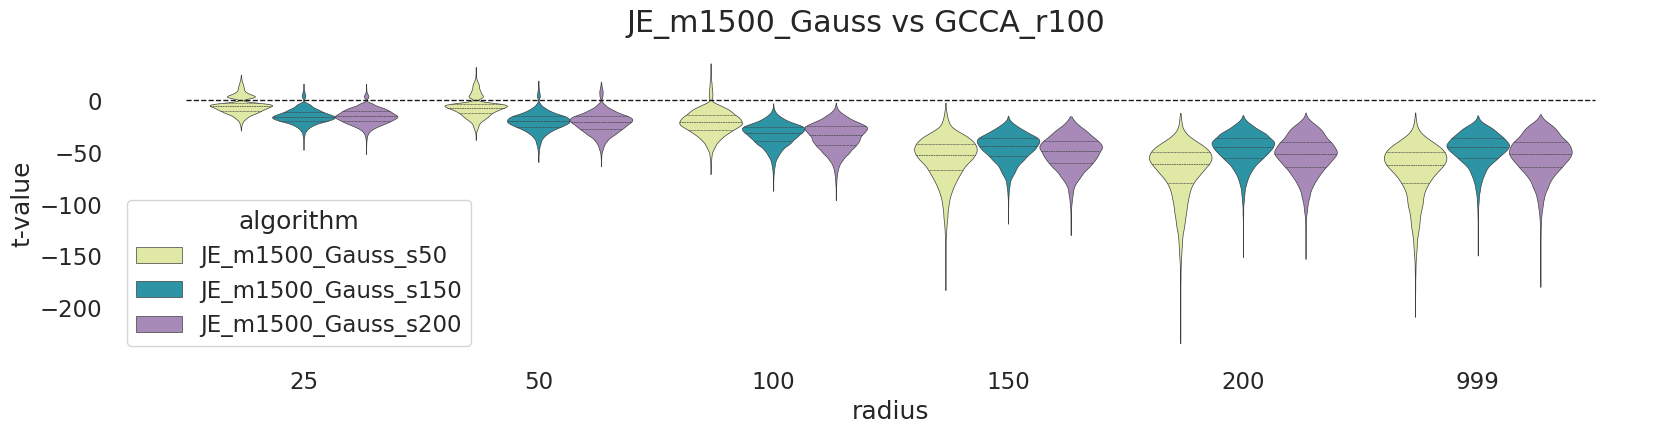

In [50]:
# Plot results of within subject variability
from variograd_utils import *
from surfplot import Plot
import seaborn as sns
import pandas as pd

allgorithm1 = "JE_m1500_Gauss"
allgorithm2 = "GCCA_r100"
radius = 0
h = "L"
cmap = bowrain([0, .33, .66, 1])




tvalues = np.load(dataset().outpath(f"{dataset().id}.{h}.wss_t_maps.npz"))
pvalues = np.load(dataset().outpath(f"{dataset().id}.{h}.wss_p_maps.npz"))
comparisons = [alg for alg in tvalues.keys() if alg.startswith(allgorithm1) and alg.endswith(allgorithm2)]


t_all = pd.DataFrame(columns=[25,50,100,150,200,999])
for comp in comparisons:
    t = tvalues[comp]
    t[pvalues[comp] > .05] = np.nan
    t = pd.DataFrame(t.T, columns=[25,50,100,150,200,999])
    t["algorithm"] = comp.split("-vs-")[0]
    t_all = pd.concat([t_all, t])

t_all = t_all.melt(id_vars="algorithm", var_name="radius", value_name="t-value")



sns.set_theme(font_scale=1.5, style="white")
plot = sns.violinplot(data=t_all, x="radius", y="t-value", hue="algorithm", 
                      linewidth=.5, palette=cmap, cut=0, inner="quartile", 
                      density_norm="width")
plot.axes.hlines([0], *plot.axes.get_xlim(), linestyles="--", colors="k", linewidth=1)
plot.axes.set_frame_on(False)
plot.axes.set_facecolor("w")

plot.legend(loc="lower left", title="algorithm")
plot.figure.set_size_inches(20, 4)
plot.figure.suptitle(f"{allgorithm1} vs {allgorithm2}")
plot.figure.set(facecolor="none")


del t_all

Text(0.5, 0.98, '')

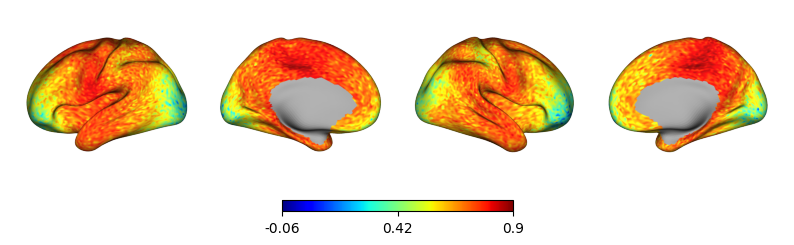

In [10]:

cmap = "jet"
radius = 5

rl = np.load(dataset().outpath("All.L.within_subj_similarity.npz"))["JE_m1500_linear_s100"][0,radius]
rr = np.load(dataset().outpath("All.R.within_subj_similarity.npz"))["JE_m1500_linear_s100"][0,radius]
data = {"left": left_cortex_data_10k(rl), 
        "right": right_cortex_data_10k(rr)} 
lh = dataset().group_dir + "/10k_fs_LR/S1200.L.inflated_MSMAll.10k_fs_LR.surf.gii"
rh = dataset().group_dir + "/10k_fs_LR/S1200.R.inflated_MSMAll.10k_fs_LR.surf.gii"

# max = np.max([abs(data["left"]), abs(data["right"])])
# min = np.min([abs(data["left"]), abs(data["right"])])
# color_range = (min, max)
p = Plot(surf_lh=lh, surf_rh=rh, layout="row", zoom=1.2, size=(900,200))
p.add_layer(data, cmap=cmap, cbar=True)
fig = p.build()
fig.set_facecolor("none")
fig.suptitle("")

### Between subjects similarity

In [20]:
# compute between-subject similarity

import numpy as np
from variograd_utils import *
from joblib import Parallel, delayed
from itertools import combinations
from os.path import exists

overwrite = True
algorithm = ["JE_m1500_Cauchy", "JE_m1500_Gauss", "JE_m1500_linear", "GCCA"]


data =  dataset()
embed_l, embed_r = (data.load_embeddings("L", algorithm), data.load_embeddings("R", algorithm))

data.subj_list = data.subj_list      ####################
n_subj = len(data.subj_list)         #################### can be removed and changed to data.N downstream
n_comps = embed_l[list(embed_l.keys())[0]].shape[2]
n_ks = len(embed_l.keys())
vinfo = vertex_info_10k

subj_pairs = list(combinations(data.subj_list, 2))



skip_algs_l = skip_algs_r =[]
if exists(data.outpath("All.L.between_subj_similarity.npz")) and not overwrite:
    skip_algs_l = np.load(data.outpath(f"All.L.between_subj_similarity.npz")).keys()
if exists(data.outpath("All.R.between_subj_similarity.npz")) and not overwrite:
    skip_algs_r = np.load(data.outpath(f"All.R.between_subj_similarity.npz")).keys()



for k in embed_l.keys():
    try:
        if k in skip_algs_l and not overwrite:
            print(f"{k} skipped")
            continue

        correlations_l = {k: np.zeros([len(subj_pairs), vinfo.grayl.size])}
        correlations_r = {k: np.zeros([len(subj_pairs), vinfo.grayr.size])}
        
        
        correlations_l = Parallel(n_jobs=-2, prefer="threads")(delayed(vector_wise_corr)(subject(i).load_embeddings("L", k)[k].T, 
                                                                                        subject(j).load_embeddings("L", k)[k].T) 
                                                                                        for i, j in subj_pairs)
        npz_update(data.outpath("All.L.between_subj_similarity.npz"), {k: np.array(correlations_l)})
        
        correlations_r = Parallel(n_jobs=-2, prefer="threads")(delayed(vector_wise_corr)(subject(i).load_embeddings("R", k)[k].T, 
                                                                                        subject(j).load_embeddings("R", k)[k].T) 
                                                                                        for i, j in subj_pairs)
        npz_update(data.outpath("All.R.between_subj_similarity.npz"), {k: np.array(correlations_r)})
        
        print(f"{k} completed")

    except:
        print(k)
        


GCCA_r10 completed
GCCA_r100 completed
JE_m1500_Cauchy_s50 completed
JE_m1500_Cauchy_s100 completed
JE_m1500_Cauchy_s150 completed
JE_m1500_Cauchy_s200 completed
JE_m1500_Gauss_s50 completed
JE_m1500_Gauss_s150 completed
JE_m1500_Gauss_s200 completed
JE_m1500_linear_s50 completed
JE_m1500_linear_s100 completed


/home/fralberti/Code/VarioGrad/variograd_utils/core_utils.py:343: RuntimeWarning: invalid value encountered in divide
  return np.sum(A * B, axis=0) / (np.linalg.norm(A, axis=0) * np.linalg.norm(B, axis=0))


JE_m1500_linear_s150 completed


In [ ]:
# Compare  between subject similarity

import numpy as np
from variograd_utils import *
from itertools import combinations
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection


algorithm = ["JE_m1500_Cauchy", "JE_m1500_Gauss", "JE_m1500_linear", "GCCA"]
alpha = 0.05

data = dataset()

for h in ["L", "R"]:
    t_maps = {}
    p_maps = {}

    alg_pairs = combinations(algorithm, 2)
        
    correlations = np.load(data.outpath(f"All.{h}.between_subj_similarity.npz"))

    param_pairs = []
    for alg_i, alg_j in alg_pairs:
        param_pairs.extend([ (i, j) for i in correlations.keys() for j in correlations.keys()
                            if i.startswith(alg_i) and j.startswith(alg_j)])

    for param_i, param_j in param_pairs: 
        X = correlations[param_i]
        Y = correlations[param_j]
        results = ttest_rel(X, Y)
        pvalues = fdrcorrection(results.pvalue, alpha)[1]

        t_maps[f"{param_i}-vs-{param_j}"] = results.statistic
        p_maps[f"{param_i}-vs-{param_j}"] = pvalues
        print(f"{h} - {param_i}-vs-{param_j}")

    npz_update(data.outpath(f"{data.id}.{h}.bss_t_maps.npz"), t_maps)
    npz_update(data.outpath(f"{data.id}.{h}.bss_p_maps.npz"), p_maps)
    
    


In [11]:
list(np.load(dataset().outpath(f"{dataset().id}.L.bss_t_maps.npz")).keys())

['JE_m1500_Cauchy_s100-vs-GCCA_r10',
 'JE_m1500_Cauchy_s100-vs-GCCA_r100',
 'JE_m1500_Cauchy_s50-vs-GCCA_r10',
 'JE_m1500_Cauchy_s50-vs-GCCA_r100',
 'JE_m1500_Cauchy_s150-vs-GCCA_r10',
 'JE_m1500_Cauchy_s150-vs-GCCA_r100',
 'JE_m1500_Cauchy_s200-vs-GCCA_r10',
 'JE_m1500_Cauchy_s200-vs-GCCA_r100',
 'JE_m1500_Gauss_s50-vs-GCCA_r10',
 'JE_m1500_Gauss_s50-vs-GCCA_r100',
 'JE_m1500_Gauss_s150-vs-GCCA_r10',
 'JE_m1500_Gauss_s150-vs-GCCA_r100',
 'JE_m1500_Gauss_s200-vs-GCCA_r10',
 'JE_m1500_Gauss_s200-vs-GCCA_r100',
 'JE_m1500_linear_s50-vs-GCCA_r10',
 'JE_m1500_linear_s50-vs-GCCA_r100',
 'JE_m1500_linear_s100-vs-GCCA_r10',
 'JE_m1500_linear_s100-vs-GCCA_r100',
 'JE_m1500_linear_s150-vs-GCCA_r10',
 'JE_m1500_linear_s150-vs-GCCA_r100',
 'JE_m1500_Gauss_s50-vs-JE_m1500_linear_s50',
 'JE_m1500_Gauss_s50-vs-JE_m1500_linear_s100',
 'JE_m1500_Gauss_s50-vs-JE_m1500_linear_s150',
 'JE_m1500_Gauss_s150-vs-JE_m1500_linear_s50',
 'JE_m1500_Gauss_s150-vs-JE_m1500_linear_s100',
 'JE_m1500_Gauss_s150-vs-JE

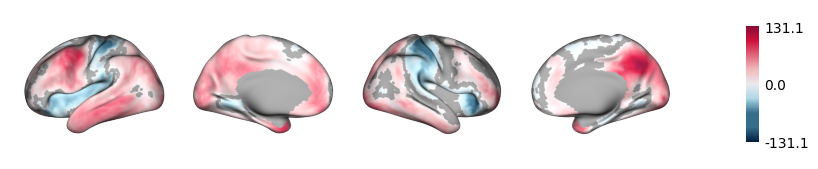

In [24]:
# Plot results of between subject variability
from variograd_utils import *
from surfplot import Plot
import seaborn as sns

comparison = "JE_m1500_Cauchy_s150-vs-JE_m1500_Gauss_s150"
cmap = coldhot

tl = np.load(dataset().outpath(f"{dataset().id}.L.bss_t_maps.npz"))[comparison]
tr = np.load(dataset().outpath(f"{dataset().id}.R.bss_t_maps.npz"))[comparison]
pl = np.load(dataset().outpath(f"{dataset().id}.L.bss_p_maps.npz"))[comparison]
pr = np.load(dataset().outpath(f"{dataset().id}.R.bss_p_maps.npz"))[comparison]

signed_pl = (-1)**(tl > 0) * np.log(pl)
signed_pr = (-1)**(tr > 0) * np.log(pr)
signed_pl[pl>=0.05] = 0
signed_pr[pr>=0.05] = 0

data = {"left": left_cortex_data_10k(signed_pl), 
        "right": right_cortex_data_10k(signed_pr)} 
lh = dataset().group_dir + "/10k_fs_LR/S1200.L.inflated_MSMAll.10k_fs_LR.surf.gii"
rh = dataset().group_dir + "/10k_fs_LR/S1200.R.inflated_MSMAll.10k_fs_LR.surf.gii"

max = np.max([abs(data["left"]), abs(data["right"])])
color_range = (-max, max)
p = Plot(surf_lh=lh, surf_rh=rh, layout="row", zoom=1.2, size=(900,200))
p.add_layer(data, cmap=cmap, color_range=color_range)
fig = p.build(cbar_kws={"location": "right", "aspect":9, "shrink":.5, "draw_border":False})
fig.set_facecolor("none")

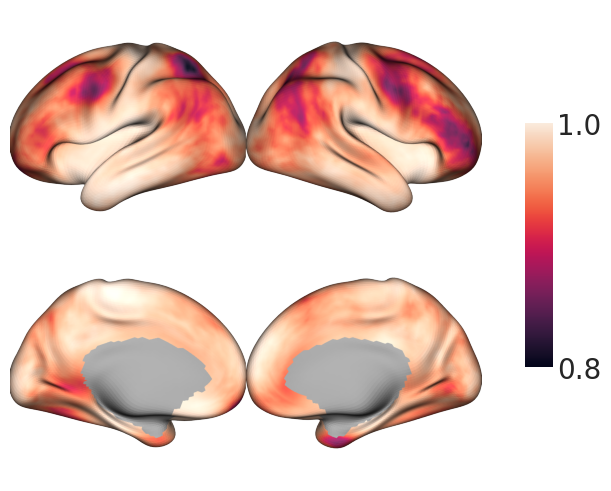

In [18]:
from surfplot import Plot
import numpy as np
from variograd_utils import *
import seaborn

correlations_l = np.arctanh(np.load(dataset().outpath(f"All.L.between_subj_similarity.npz"))["JE_m1500_Cauchy_s200"])
correlations_r = np.arctanh(np.load(dataset().outpath(f"All.R.between_subj_similarity.npz"))["JE_m1500_Cauchy_s200"])
cmap = "rocket"

data = {"left": left_cortex_data_10k(np.tanh(correlations_l.mean(axis=0))), 
        "right": right_cortex_data_10k(np.tanh(correlations_r.mean(axis=0)))} 
lh = dataset().group_dir + "/10k_fs_LR/S1200.L.inflated_MSMAll.10k_fs_LR.surf.gii"
rh = dataset().group_dir + "/10k_fs_LR/S1200.R.inflated_MSMAll.10k_fs_LR.surf.gii"


kws = {'location': 'right', 'decimals': 1,
'fontsize': 20, 'n_ticks': 2, 'shrink': 8, 'aspect': 9,
'draw_border': False}
p = Plot(surf_lh=lh, surf_rh=rh, layout="grid", zoom=1.3, size=(600,600))
p.add_layer(data, cmap=cmap, cbar=True)
fig = p.build(cbar_kws=kws)
fig.set_facecolor("none")

/tmp/ipykernel_551606/4022699811.py:30: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  plot = sns.violinplot(data=t_all, hue_order=t_all.columns, order=t_all.columns,


[None]

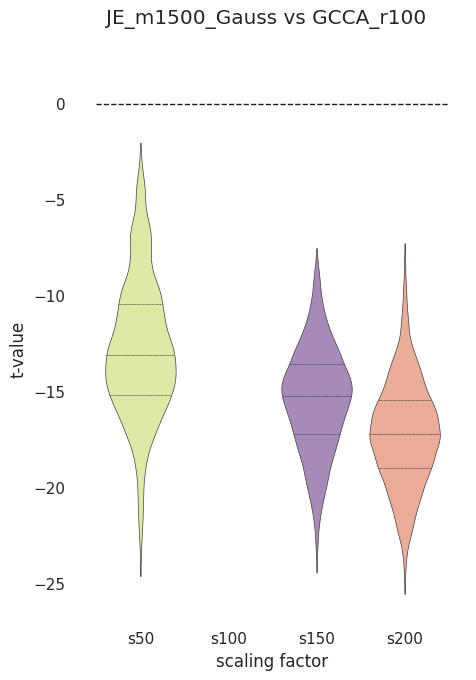

In [47]:
# Plot results of within subject variability
from variograd_utils import *
from surfplot import Plot
import seaborn as sns
import pandas as pd

allgorithm1 = "JE_m1500_Gauss"
allgorithm2 = "GCCA_r100"
radius = 0
h = "L"
cmap = bowrain([0, .33, .66, 1])




tvalues = np.load(dataset().outpath(f"{dataset().id}.{h}.bss_t_maps.npz"))
pvalues = np.load(dataset().outpath(f"{dataset().id}.{h}.bss_p_maps.npz"))
comparisons = [alg for alg in tvalues.keys() if alg.startswith(allgorithm1) and alg.endswith(allgorithm2)]


t_all = pd.DataFrame(columns=["s50", "s100"])

for comp in comparisons:
    t = tvalues[comp]
    t[pvalues[comp] > .05] = np.nan
    t_all[comp.split("-vs-")[0].split("_")[-1]] = t


sns.set_theme(font_scale=1, style="white")
plot = sns.violinplot(data=t_all, hue_order=t_all.columns, order=t_all.columns,
                      linewidth=.5, palette=cmap, cut=0, inner="quartile")
plot.axes.hlines([0], *plot.axes.get_xlim(), linestyles="--", colors="k", linewidth=1)
plot.axes.set_frame_on(False)
plot.axes.set_facecolor("w")
plot.axes.set(xlabel="scaling factor", ylabel="t-value")

plot.figure.set_size_inches(5, 7)
plot.figure.suptitle(f"{allgorithm1} vs {allgorithm2}")
plot.figure.set(facecolor="none")


### Discriminability

In [21]:
# identification accuracy

import numpy as np
from variograd_utils import *
import gc
from os.path import exists

algorithm = ["JE_m1500", "GCCA"]
h="L"

data =  dataset()
LEl, LEr = (data.load_embeddings("L", algorithm), data.load_embeddings("R", algorithm))

data.subj_list = data.subj_list
n_subj = len(data.subj_list)
n_comps = LEl[list(LEl.keys())[0]].shape[2]
n_ks = len(LEl.keys())

if exists(data.outpath(f"All.{h}.embed_detection_mats.npz")):
        skip_algs = np.load(data.outpath(f"All.{h}.embed_detection_mats.npz")).keys()
        
corrmats_l = {k: np.zeros([n_comps, n_subj, n_subj]) for k in LEl.keys() if k not in skip_algs}
corrmats_r = {k: np.zeros([n_comps, n_subj, n_subj]) for k in LEr.keys() if k not in skip_algs}

corrmats_l = {k: np.zeros([n_comps, n_subj, n_subj]) for k in LEl.keys()}
corrmats_r = {k: np.zeros([n_comps, n_subj, n_subj]) for k in LEr.keys()}

for key, embed in LEl.items():
    if key in skip_algs:
         print(key, "skipped")
         continue

    for id in data.subj_list:
        subj_i = subject(id)
        i = subj_i.idx
        gdist_vec_i =subj_i.load_gdist_triu(h).reshape(-1, 1)

        
        for j, edist_vec_j in enumerate(embed):
            gdist_vec_i_cpy = gdist_vec_i.copy()
            edist_vec_j = euclidean_triu(edist_vec_j)
            R = vector_wise_corr(gdist_vec_i_cpy, edist_vec_j)
            del edist_vec_j
            gc.collect()


            corrmats_l[key][:, i, j] = R
        
    print(key, "completed")

npz_update(data.outpath(f"All.{h}.embed_detection_mats.npz"), corrmats_l)

detection_pct_l = {}
for key, mats in corrmats_l.items():
    detection_pct_l[key] = np.array([(M > np.diagonal(M)).mean() * 100 for M in mats])

npz_update(data.outpath(f"All.{h}.detection_pct.npz"), detection_pct_l)

GCCA_r10 skipped
GCCA_r100 skipped
JE_m1500_Cauchy_s50 completed
JE_m1500_Cauchy_s100 completed
JE_m1500_Cauchy_s150 completed
JE_m1500_Cauchy_s200 completed


KeyboardInterrupt: 

# Visualizations

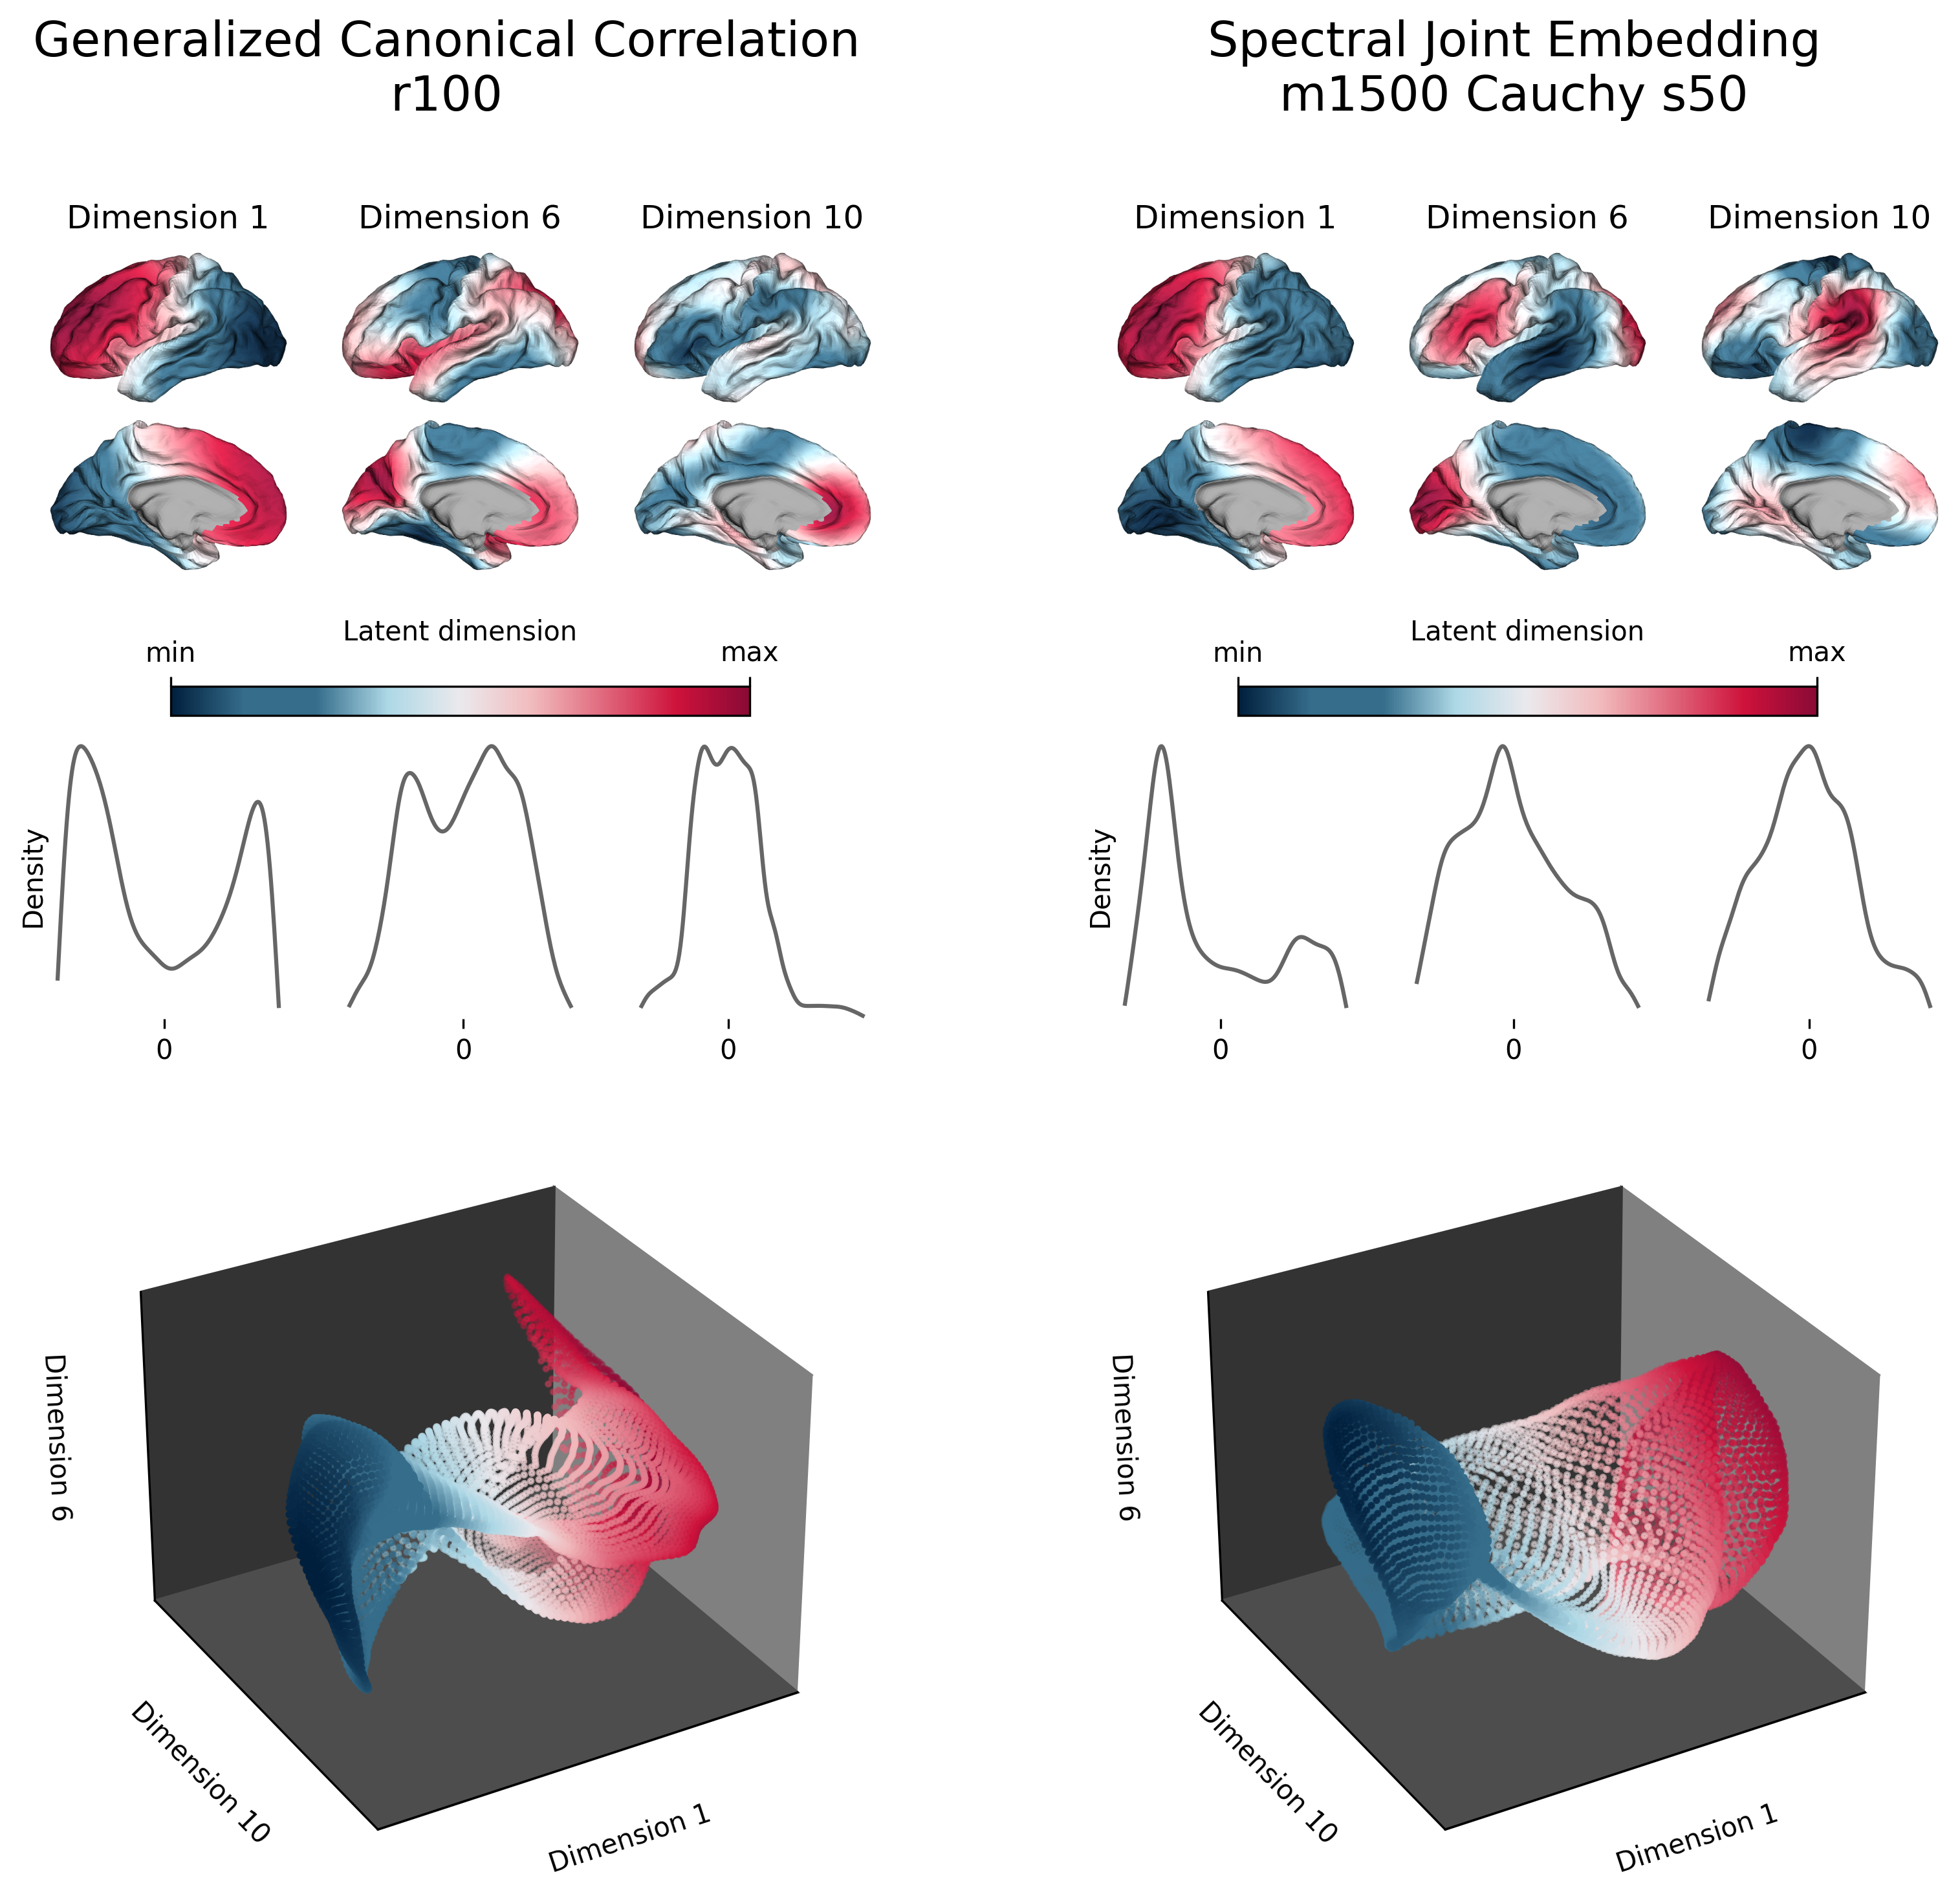

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from variograd_utils import *
from surfplot import Plot
import matplotlib as mpl

dims = [0, 5, 9]

def Plot_to_numpy(plot):
    plot = plot.render()
    plot._check_offscreen()
    return plot.to_numpy()


h = "L"
methods = ["GCCA_r100", "JE_m1500_Cauchy_s50"] 
abbreviations = {"LE":"Laplacian Eigenmaps", "DE":"Diffusion-map Embedding", "JE":"Spectral Joint Embedding", 
              "PCA":"Principal Component Analysis", "GCCA":"Generalized Canonical Correlation"}
full_names = {m: (f"{abbreviations[m.split('_')[0]]}\n{' '.join(m.split('_')[1:])}" if len(m) > 4 
                  else f"{abbreviations[m.split('_')[0]]}") for m in methods}
data = dataset()
N = data.N

cmap1 = coldhot
cmap2 = quitefire.reversed()
mpl.rcParams['axes.labelpad'] = 0

f = plt.figure(figsize=[5.5*len(methods), 11], dpi=300)
f.set_facecolor("none")
sf = f.subfigures(1, len(methods))
if len(methods)==1:
    sf = [sf]

ref = None
for i, m in enumerate(methods):

    sf[i].set_facecolor("none")
    sf[i].suptitle(full_names[m], size=18, fontweight=3)

    emb_m = np.array([value for key, value in data.load_embeddings(h, m).items()])
    emb_avg = emb_m.mean(axis=0).mean(axis=0)
    ref =  [emb_avg if ref is None else ref][0]
    emb_avg[:, vector_wise_corr(emb_avg, ref) < 0]  *= -1 # type: ignore

    
    surf = getattr(data, f"{h}_midthickness_10k")
    cortex_data_10k = [left_cortex_data_10k if h=="L" else right_cortex_data_10k][0]

    for j, d in enumerate(dims):
        p = Plot(surf_lh=surf, layout="column", zoom=1.75, size=(400,550))
        p.add_layer(cortex_data_10k(emb_avg[:, d]), cmap=cmap1)

        axj = sf[i].add_subplot(4, 3, j+1, title=f"Dimension {d+1}")
        axj.imshow(Plot_to_numpy(p))
        axj.axis("off")
        
    
    axs = []
    for k, d in enumerate(dims):
        axk = sf[i].add_subplot(4,3,k+4)
        axk.set_frame_on(False)
        axk.set(xticks=[0], yticks=[], ylabel=["Density" if k==0 else ""][0])
        sns.kdeplot(emb_avg[:,d], ax=axk, c=".4", cut=0)
        axs.append(axk)
    
    norm = mpl.colors.Normalize(vmin=emb_avg[:,dims].min(), vmax=emb_avg[:,dims].max())
    scal = mpl.cm.ScalarMappable(norm=norm, cmap=cmap1)
    cb = sf[i].colorbar(scal, ax=axs, location="top", label="Latent dimension", shrink=.7)
    cb.set_ticks(ticks=[norm.vmin, norm.vmax], labels=["min", "max"])


    ax3d = sf[i].add_subplot(2,1,2, projection="3d")
    ax3d.view_init(azim=-120) 
    ax3d.set(xlabel=f"Dimension {dims[0]+1}", ylabel=f"Dimension {dims[2]+1}", zlabel=f"Dimension {dims[1]+1}", 
             xticks=[], yticks=[], zticks=[], facecolor="none")
    ax3d.xaxis.set_pane_color(".5"); ax3d.yaxis.set_pane_color(".2"); ax3d.zaxis.set_pane_color(".3")
    s = ax3d.scatter(emb_avg[:,dims[0]], emb_avg[:,dims[2]], emb_avg[:,dims[1]], s=3, 
                     c=emb_avg[:,0], cmap=cmap1)




In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
from variograd_utils import *
from surfplot import Plot
import matplotlib as mpl
from surfdist.utils import surf_keep_cortex
from scipy.stats import rankdata

dims = [0, 5, 9]

def Plot_to_numpy(plot):
    plot = plot.render()
    plot._check_offscreen()
    return plot.to_numpy()


h = "L"
methods = ["JE_m1500_Cauchy_s50","GCCA_r100"]
abbreviations = {"LE":"Laplacian Eigenmaps", "DE":"Diffusion-map Embedding", "JE":"Joint Embedding", 
              "PCA":"Principal Component Analysis", "GCCA":"Generalized Canonical Correlation"}
full_names = {m: (f"{abbreviations[m.split('_')[0]]}\n{' '.join(m.split('_')[1:])}" if len(m) > 4 
                  else f"{abbreviations[m.split('_')[0]]}") for m in methods}

data = dataset()
embed_dist = np.load(data.outpath(f"All.{h}.embedded_dist.npz"))
anat_dist = np.load(data.outpath(f"AllToAll.{h}.gdist_L2.npy"))

cmap1 = bowrain
cmap2 = quitefire.reversed()
mpl.rcParams['axes.labelpad'] = 0

f = plt.figure(figsize=[5.5*len(methods), 11], dpi=300)
f.set_facecolor("none")
sf = f.subfigures(1, len(methods))
if len(methods)==1:
    sf = [sf]

v = 2483
vdist = data.load_gdist_matrix(h)[:,v]
ranks = rankdata(vdist)
full_surf = [darray.data for darray in data.load_surf(h, 10, "cortex_midthickness").darrays]
cortex_surf = surf_keep_cortex(full_surf, cortex=np.argwhere(ranks < 100).squeeze())
x, y, z = cortex_surf[0].T


for i, m in enumerate(methods):

    sf[i].set_facecolor("none")
    sf[i].suptitle(full_names[m], size=18, fontweight=3)

    edist_avg = np.array([value for key, value in embed_dist.items() if key.startswith(m)]).mean(axis=0)
    emb_m = np.array([value for key, value in data.load_embeddings(h, m).items()])
    emb_avg = emb_m.mean(axis=0)
    emb_var = emb_m.var(axis=1).mean(axis=0)
    

    n_keys = len(data.load_embeddings(h, m).keys())
    
    surf = getattr(data, f"{h}_midthickness_10k")
    cortex_data_10k = [left_cortex_data_10k if h=="L" else right_cortex_data_10k][0]

    ax123 = []
    for j, d in enumerate(dims):
        p = Plot(surf_lh=surf, layout="column", zoom=1.75, size=(400,550))
        p.add_layer(cortex_data_10k(emb_var[:, d]), cmap=cmap2)

        axj = sf[i].add_subplot(4, 3, j+1, title=f"Dimension {d+1}")
        axj.imshow(Plot_to_numpy(p))
        axj.axis("off")
        ax123.append(axj)
    
    for k, d in enumerate(dims):
        axk = sf[i].add_subplot(4,3,k+4)
        sns.scatterplot(x=anat_dist[v], y=edist_avg[d, v, :], s=5)

        axk.set(xticks = axk.get_xticks()[[1, -2]], 
                yticks=[axk.get_yticks()[[1, -2]] if k==0 else []][0], 
                ylabel=["Embedded distance" if k==0 else ""][0],
                xlabel=["Euclidean distance of geodesic distance vectors " if k==1 else ""][0])

    
    norm = mpl.colors.Normalize(vmin=emb_var[:, dims].min(), vmax=emb_var[:, dims].max())
    scal = mpl.cm.ScalarMappable(norm=norm, cmap=cmap2)
    cb = sf[i].colorbar(scal, ax=ax123, location="bottom", label="Inter-individual variance", shrink=.7)
    cb.set_ticks(ticks=cb.get_ticks()[[1, -2]], labels=["low", "high"])


    ax7 = sf[i].add_subplot(4, 3, 8, projection="3d")
    ax7.plot_trisurf(x, y, z, triangles=cortex_surf[1], linewidth=.5, antialiased=True, color=".8", edgecolor="k", zorder=0)
    ax7.plot(full_surf[0][v, 0],full_surf[0][v, 1], full_surf[0][v, 2], marker="o", c="darkred", markersize=4, alpha=1, zorder=10, markeredgecolor="w", linewidth=.01)
    ax7.view_init(elev=0, azim=180)
    radius = max([np.diff(ax7.get_xlim())[0], np.diff(ax7.get_ylim())[0], np.diff(ax7.get_zlim())[0]]) / 2
    centers = np.array([np.mean(ax7.get_xlim()), np.mean(ax7.get_ylim()), np.mean(ax7.get_zlim())])
    lims = np.vstack([centers-radius, centers+radius]).T
    ax7.set_xlim(lims[0]); ax7.set_ylim(lims[1]); ax7.set_zlim(lims[2])
    ax7.set_axis_off()
    ax7.set(facecolor="none")


    ax8 = sf[i].add_subplot(4,2,5)
    ax8.set_frame_on(False)
    ax8.set(xlabel=f"Dimension {dims[1]+1}", ylabel=f"Dimension {dims[0]+1}", 
             xticks=[], yticks=[], facecolor="none")
    ax8.scatter(emb_avg[:, ranks<100, dims[1]].mean(axis=0), emb_avg[:, ranks<100, dims[0]].mean(axis=0), s=10, c=".8", zorder=0)
    ax8.scatter(emb_avg[:, v, dims[1]].mean(axis=0), emb_avg[:, v, dims[0]].mean(axis=0), s=40, c="darkred", zorder=15, edgecolor="w")
    ax8.scatter(emb_avg[:, v, dims[1]], emb_avg[:, v, dims[0]], s=40, c=range(data.N), cmap=cmap1, alpha=1, edgecolor=".4", zorder=5)
    

    ax9 = sf[i].add_subplot(4,2,6)
    ax9.set_frame_on(False)
    ax9.set(xlabel=f"Dimension {dims[2]+1}", ylabel=r"", xticks=[], yticks=[], facecolor="none")
    ax9.scatter(emb_avg[:, ranks<100, dims[2]].mean(axis=0), emb_avg[:, ranks<100, dims[0]].mean(axis=0), s=10, c=".8", zorder=0)
    ax9.scatter(emb_avg[:, v, dims[2]].mean(axis=0), emb_avg[:, v, dims[0]].mean(axis=0), s=40, c="darkred", zorder=15, edgecolor="w")
    ax9.scatter(emb_avg[:, v, dims[2]], emb_avg[:, v, dims[0]], s=40, c=range(data.N), cmap=cmap1, alpha=.8, edgecolor=".4", zorder=5)


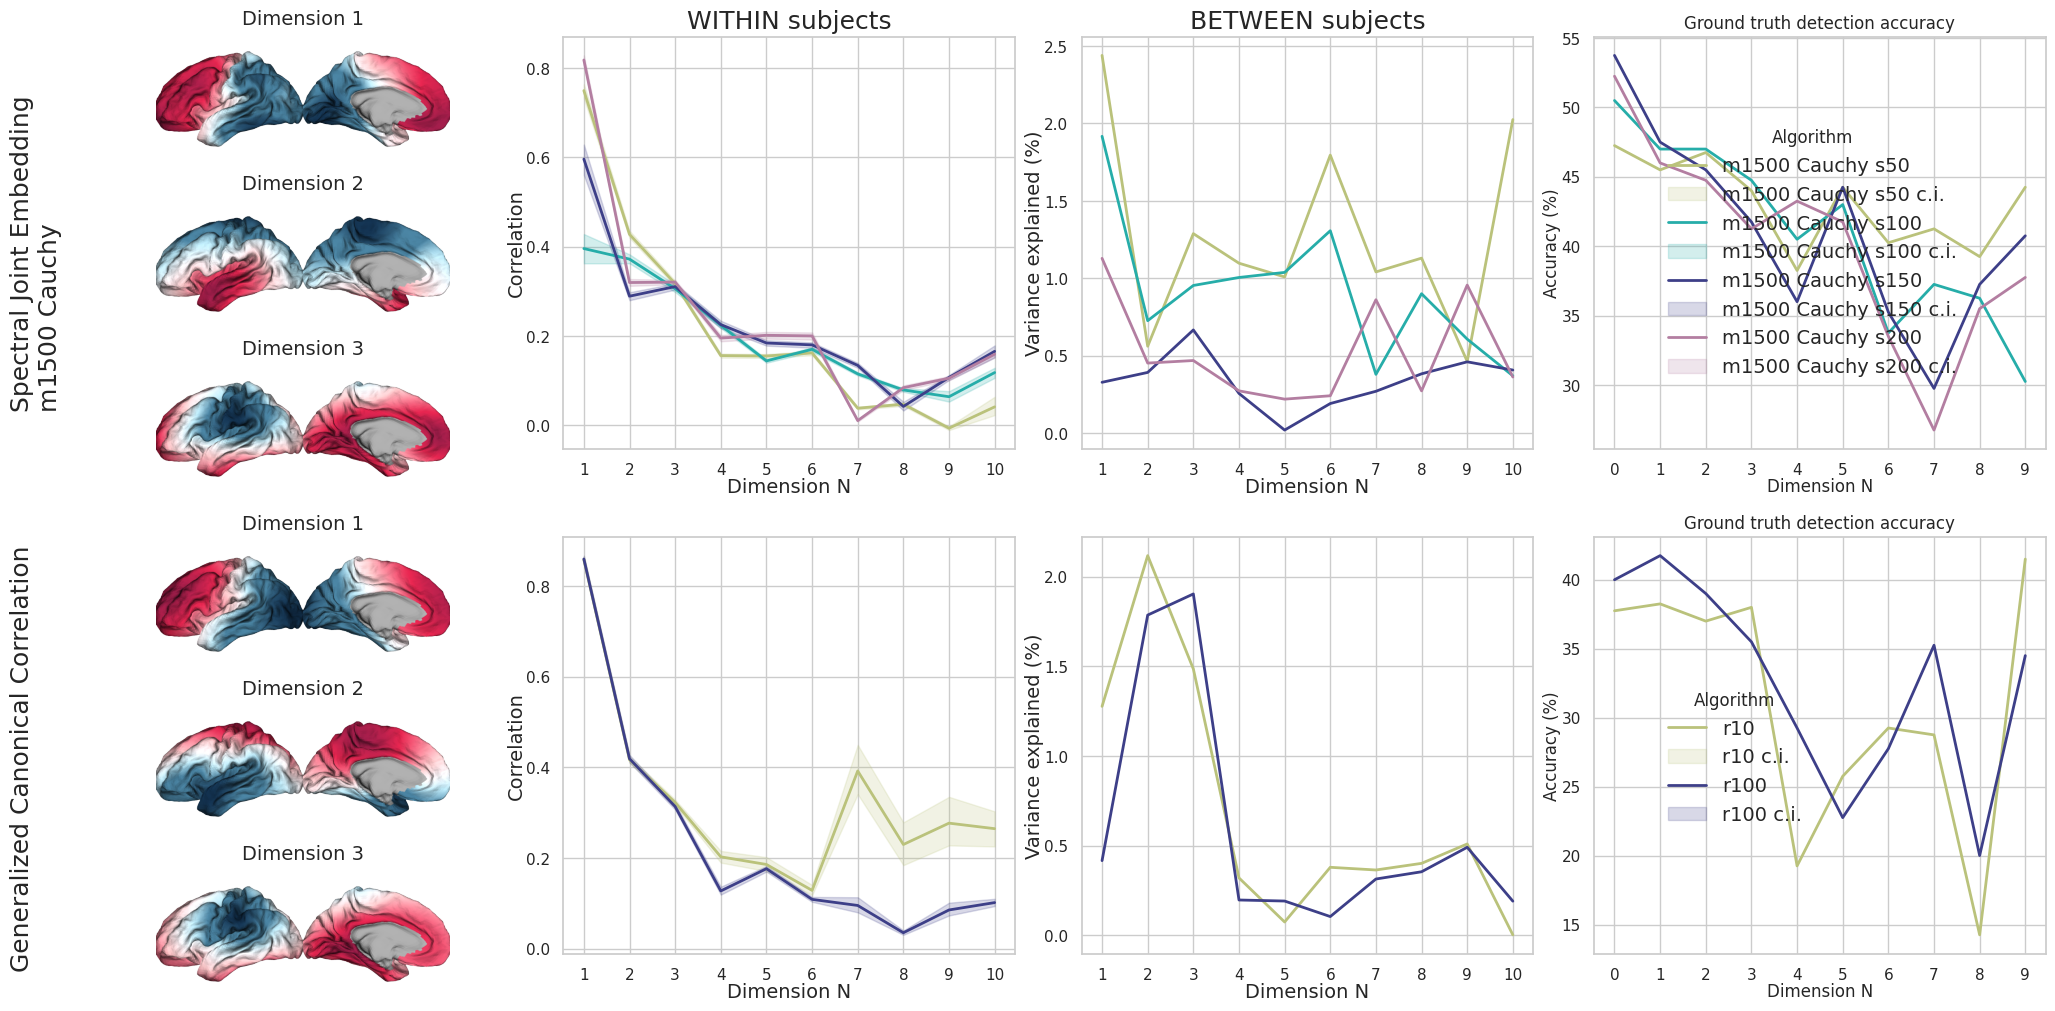

In [69]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from variograd_utils import *
from surfplot import Plot

h = "L"
methods = ["JE_m1500_Cauchy", "GCCA"]
cmap1 = coldhot
cmap2 = bowrain
fsize1 = 18
fsize2 = 14




abbreviations = {"LE":"Laplacian Eigenmaps", "DE":"Diffusion-map Embedding", "JE":"Spectral Joint Embedding", 
              "PCA":"Principal Component Analysis", "GCCA":"Generalized Canonical Correlation"}
full_names = {m: (f"{abbreviations[m.split('_')[0]]}\n{' '.join(m.split('_')[1:])}" if len(m) > 4 
                  else f"{abbreviations[m.split('_')[0]]}") for m in methods}
data = dataset()
N = data.N
embed_gdist_corr = np.load(data.outpath(f"AllToAll.{h}.embed_gdist_correlation.npz"))
vertex_dist_corr = np.load(data.outpath(f"AllToAll.{h}.vertex_dist_R2.npz"))
detection_pct = pd.DataFrame(dict( np.load(data.outpath(f"All.{h}.detection_pct.npz"))))

# dims_to_plot = [np.sort((-vertex_dist_corr[m]).argpartition(3, axis=None)[:3]) for m in methods]
dims_to_plot = [[0,1,2], [0,1,2]]

f = plt.figure(figsize=[20,5*len(methods)], layout='constrained') 
f.set_facecolor("none")
sf = f.subfigures(len(methods), 1)
if len(methods)==1:
    sf = [sf]


def Plot_to_numpy(plot):
    plot = plot.render()
    plot._check_offscreen()
    return plot.to_numpy()


for i, m in enumerate(methods):

    sf[i].set_facecolor("none")
    sf[i].suptitle(full_names[m], ha='left', va='center', x=-0.02, y=0.5, rotation=-270, size=18, fontweight=3)

    egc_m = {key:value for key, value in embed_gdist_corr.items() if key.startswith(m)}
    vgc_m = {key:value for key, value in vertex_dist_corr.items() if key.startswith(m)}
    dpct_m = {key:value for key, value in detection_pct.items() if key.startswith(m)}
    emb_m = np.array([value for key, value in data.load_embeddings(h, m).items()])
    emb_m = emb_m.mean(axis=0).mean(axis=0)
    n_keys = len(data.load_embeddings(h, m).keys())
    

    sns.set_palette(cmap2(np.arange(n_keys)/n_keys) * 0.8, n_colors=n_keys) 

    surf = getattr(data, f"{h}_midthickness_10k")
    cortex_data_10k = [left_cortex_data_10k if h=="L" else right_cortex_data_10k][0]
    for j, d in enumerate(dims_to_plot[i]):

        p = Plot(surf_lh=surf, layout="row", zoom=1.4, size=(550,250))
        p.add_layer(cortex_data_10k(emb_m[:, d]), cmap=cmap1)

        axj = sf[i].add_subplot(3, 4, j+1+3*j)
        axj.imshow(Plot_to_numpy(p))
        axj.axis("off")
        axj.set_title(f"Dimension {d+1}", fontsize=fsize2)


    ax1 = sf[i].add_subplot(1,4,2)
    ax1.set(xticks=range(11), xticklabels=range(11))
    ax1.set_xlabel("Dimension N", fontsize=fsize2) 
    ax1.set_ylabel("Correlation", fontsize=fsize2) 
    if i==0:
        ax1.set_title("WITHIN subjects", fontsize=fsize1)


    for k,v in egc_m.items():
        v = pd.DataFrame(np.arctanh(v), columns=range(1,11)).stack().reset_index()
        sns.lineplot(data=v, x="level_1", y=0, ax=ax1, linewidth=2, alpha=1)

    leglab = []
    for k in egc_m.keys():
        k = " ".join(k.split("_")[1:])
        leglab.extend([k,
                       f"{k} c.i."])
    sf[i].legend(leglab, ncol=1, loc="center left", bbox_to_anchor=(.8, 0.5), 
                 frameon=False, title="Algorithm", fontsize=fsize2)


    ax2 = sf[i].add_subplot(1,4,3)
    ax2.set(xticks=range(10), xticklabels=range(1,11))
    ax2.set_xlabel("Dimension N", fontsize=fsize2) 
    ax2.set_ylabel(r"Variance explained (%)", fontsize=fsize2) 
    if i==0:
        ax2.set_title("BETWEEN subjects", fontsize=fsize1)

    lines = np.array([v for k, v in vgc_m.items()]).T
    ax2.plot(lines, linewidth=2, alpha=1)


    ax3 = sf[i].add_subplot(1,4,4)
    ax3.set(title="Ground truth detection accuracy",
                xlabel="Dimension N", ylabel="Accuracy (%)", 
                xticks=range(11), xticklabels=range(11))
    sns.lineplot(data=dpct_m, dashes=None, ax=ax3, legend=False, linewidth=2, alpha=1)


In [ ]:
from variograd_utils import *
import numpy as np

algorithm = "GCCA_r{0}" #JE_m500_s{0}_l{1}"
params = [[10], [100]]#[[s, l] for s in [50, 100, 150] for l in [2, 3, 4]]
d=2
subj = 100307
view = "lateral"

surf = dataset().L_midthickness_10k
subj = subject(subj)
surf = subj.L_midthickness_10k_T1w


def Plot_to_numpy(plot):
    plot = plot.render()
    plot._check_offscreen()
    return plot.to_numpy()

from surfplot import Plot
import matplotlib.pyplot as plt
data = dataset()

f,ax = plt.subplots(1, 2, figsize =(7,4))
ax = ax.flatten()
for i, args in enumerate(params):
    alg = algorithm.format(*args)
    L = data.load_embeddings("L", alg)[alg]
    p = Plot(surf_lh=surf, layout="row", zoom=1.25, size=(300,300), views=[view])
    p.add_layer(left_cortex_data_10k(L[subj.idx, :, d-1]), cmap=coldhot)

    ax[i].imshow(Plot_to_numpy(p))
    ax[i].set_title(alg)
    ax[i].axis("off")

f.suptitle(f"GCCA\nDimension {d}", size=20)
f.tight_layout()

In [ ]:
# Individual distance from mean surface

from variograd_utils import *
import numpy as np
from surfplot import Plot
import matplotlib.pyplot as plt
import matplotlib as mpl

# ["JE_m1500_s63_Cauchy", "JE_m1500_s84_Cauchy", "JE_m1500_s112_Cauchy", "JE_m1500_s150_Cauchy", "JE_m1500_s200_Cauchy"]
algorithm = "JE_m1500_Cauchy_s50"
dims = [0, 5, 9]

view = "lateral"
cmap1 = "jet"
cmap2  = "jet"
dim = 0

def Plot_to_numpy(plot):
    plot = plot.render()
    plot._check_offscreen()
    return plot.to_numpy()


data = dataset()
L = data.load_embeddings("L", algorithm)[algorithm]
# L = (L - L.mean(axis=0)) / L.std(axis=0)

f = plt.figure(figsize =(8.3,11.7), dpi=300)

ax = f.add_subplot(7,1,1)
p = Plot(surf_lh=data.L_midthickness_10k, layout="row", zoom=1.25, size=(1800,300), 
         views=['ventral', 'dorsal', 'lateral', 'medial', 'anterior', 'posterior'])
p.add_layer(left_cortex_data_10k(L[:, :, dim].mean(axis=0)), cmap=cmap1)
ax.imshow(Plot_to_numpy(p))
ax.set_title(f"Average surface", size=12)
ax.axis("off")

norm = mpl.colors.Normalize(vmin=L.min(), vmax=L.max())
scal = mpl.cm.ScalarMappable(norm=norm, cmap=cmap2)
f.colorbar(scal, ax=ax, location="bottom", label="Latent dimension", shrink=.7, aspect=20, ticks=[])
f.suptitle(algorithm.upper(), size=20)

for i in range(20):
    ax1 = f.add_subplot(7, 8, 2*i+9, title=2*i+7)
    surf = subject(data.subj_list[i]).L_midthickness_10k_T1w
    p = Plot(surf_lh=surf, layout="row", zoom=1.25, size=(300,300), views=[view])
    p.add_layer(left_cortex_data_10k(L[i, :, dim]), cmap=cmap1)
    ax1.imshow(Plot_to_numpy(p))
    ax1.axis("off")

    ax2 = f.add_subplot(7, 8, 2*i+10, projection="3d", title="3d")
    ax2.scatter(left_cortex_data_10k(L[i, :, dims[0]]), left_cortex_data_10k(L[i, :, dims[1]]), left_cortex_data_10k(L[i, :, dims[2]]),
                s=.1, c=left_cortex_data_10k(L[i, :, dim]), cmap=cmap1)
    ax2.set_axis_off()


In [ ]:
# plot relationship between geodesic distance and other distance measures

from variograd_utils import *
import numpy as np
from sklearn.metrics import pairwise_distances
import seaborn as sns
from scipy.stats import linregress


distances = ["cityblock", "euclidean", "cosine", 'correlation', 'dice']
            #  'braycurtis', 'canberra', 'chebyshev', 'correlation', 'dice', 'hamming', 
            #  'jaccard', 'mahalanobis', 'minkowski', 
            #  'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 
            #  'sokalsneath', 'sqeuclidean', 'yule']

v_n = vertex_info_10k.grayl.size
rand_v = np.random.randint(0, vertex_info_10k.grayl.size, v_n)
M = subject(100307).load_gdist_matrix("L").astype("float32")#[rand_v]

gd = M[np.triu_indices(len(rand_v), 1)]
bins = np.digitize(gd, np.arange(gd[gd>0].min(), gd.max()+1, gd.max()/100), right=True)

Rs = {dist: [] for dist in distances}
R2s = {dist: [] for dist in distances}

for dist in distances:
    pwd = pairwise_distances(M, metric=dist, n_jobs=3)[np.triu_indices(len(rand_v), 1)]

    for i in range(bins.max()+1):
        Rs[dist].append(np.corrcoef(gd[bins==i], pwd[bins==i])[0,1])
        R2s[dist].append(linregress(gd[bins==i], pwd[bins==i])[2]**2)
    
    print(dist)


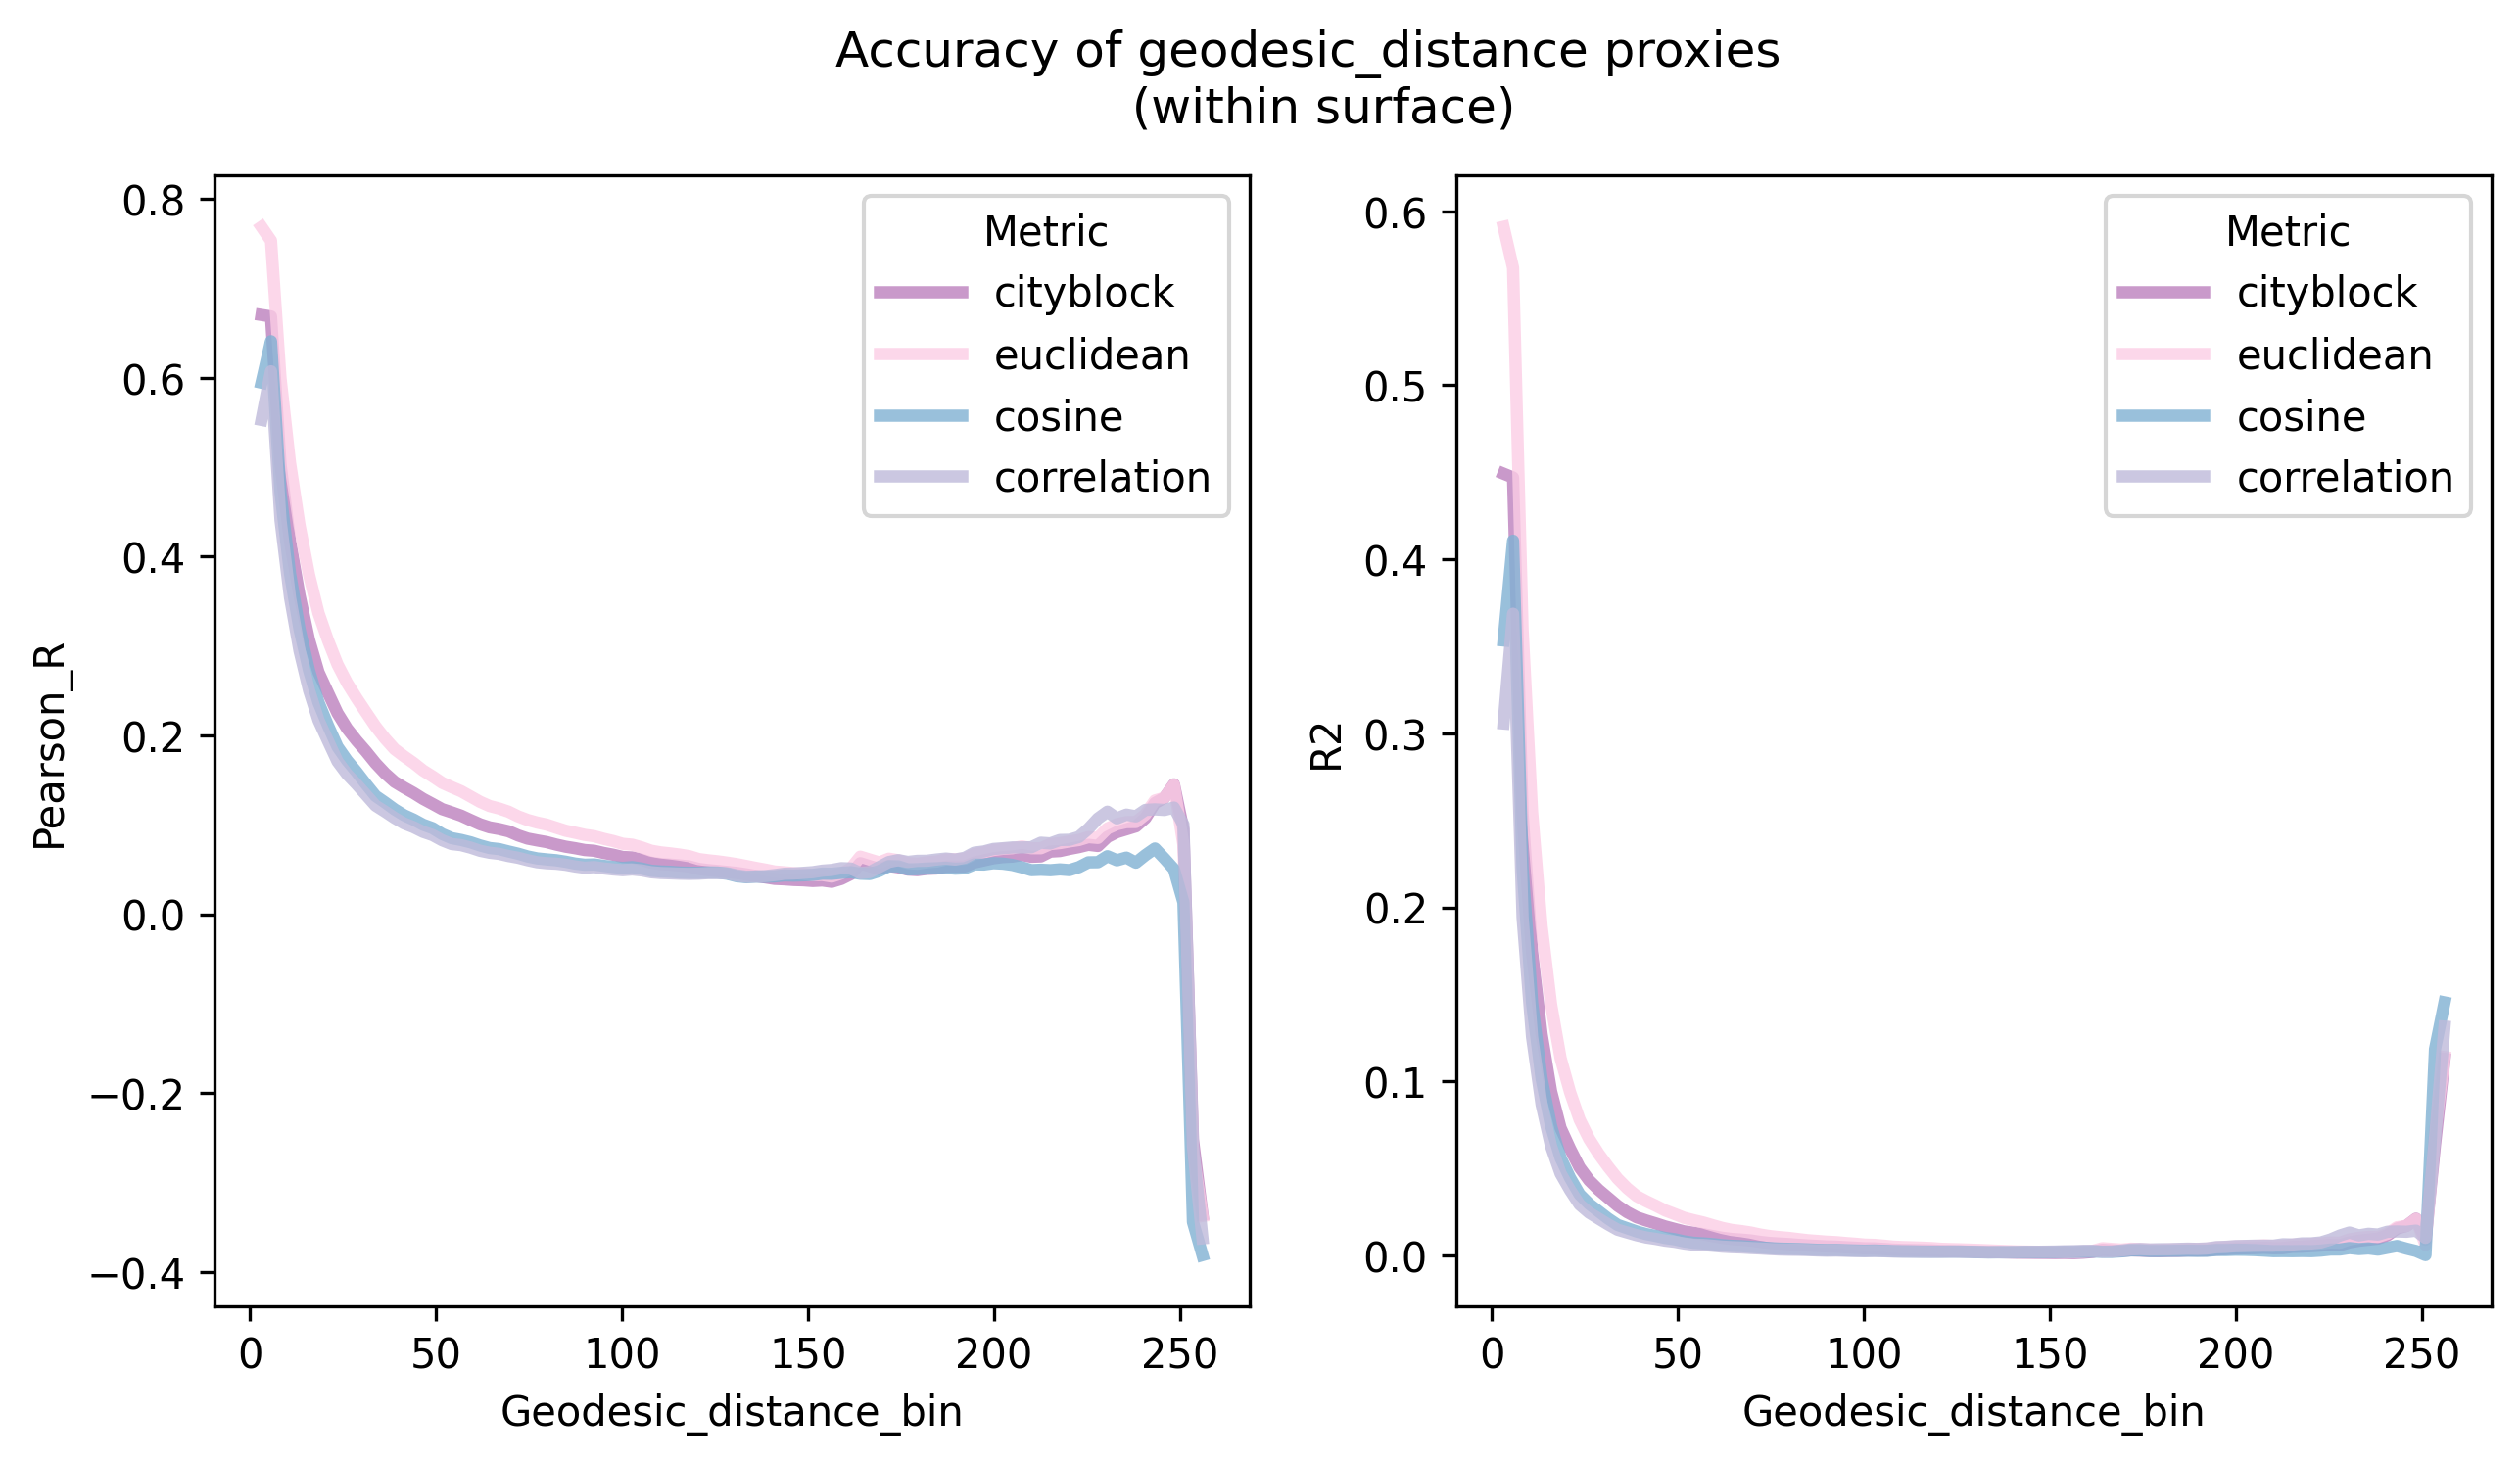

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

bin_dist = np.arange(gd[gd>0].min(), gd.max()+1, gd.max()/100)
completed_R = pd.DataFrame({k:v for k, v in Rs.items() if k!="dice"}, index=bin_dist).stack().reset_index()
completed_R.columns = ["Geodesic_distance_bin", "Metric", "Pearson_R"]
completed_R2 = pd.DataFrame({k:v for k, v in R2s.items() if k!="dice"}, index=bin_dist).drop(bin_dist[0]).stack().reset_index()
completed_R2.columns = ["Geodesic_distance_bin", "Metric", "R2"]

f, ax = plt.subplots(1,2, figsize=(10,5), dpi=300, subplot_kw={"facecolor":"w"})
f.suptitle("Accuracy of geodesic_distance proxies \n (within surface)", size=12)

palette = "Set3_r"
plot_R = sns.lineplot(data = completed_R, x="Geodesic_distance_bin", y="Pearson_R", 
                          linewidth=3, alpha=.8, hue="Metric", ax=ax[0], palette=palette)
plot_R2 = sns.lineplot(data = completed_R2, x="Geodesic_distance_bin", y="R2", 
                         linewidth=3, alpha=.8, hue="Metric", ax=ax[1], palette=palette)


## Variogram drafts

In [ ]:
# downsample gradient 1

from variograd_utils import *
import nibabel as nib
import numpy as np
import hcp_utils as hcp
from subprocess import run

dt = dataset()

grads = np.load("/home/fralberti/Data/HCP_S1200/gradient1_DME_500.npy")
template = nib.load("/home/fralberti/Data/HCP_S1200/HCP_S1200_GroupAvg_v1/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii")
command = "wb_command -cifti-resample "



for id in dt.subj_list:
    s = subject(id)
    sphere32k_path = dt.group_dir + "/S1200.{0}.sphere.32k_fs_LR.surf.gii"
    midthick32k_path = dt.group_dir + "/S1200.{0}.midthickness_MSMAll.32k_fs_LR.surf.gii"
    sphere10k_path = dt.group_dir + "/10k_fs_LR/S1200.{0}.sphere.10k_fs_LR.surf.gii"

    out = s.outpath(f"Analysis/{id}.L.DME_1.32k_fs_LR.shape.gii")
    arr = hcp.left_cortex_data(grads[grads[:,0]==id, 1:].squeeze())
    save_gifti(darrays=[arr], filename=out, dtypes=["NIFTI_TYPE_FLOAT32"])
    command = f"\
    wb_command -set-structure {out} 'CORTEX_LEFT' ;\
    wb_command -metric-resample {out} {sphere32k_path.format('L')} {sphere10k_path.format('L')} \
                                BARYCENTRIC {s.outpath(f'/Analysis/{id}.L.DME_1.10k_fs_LR.shape.gii')}"
    run(command, shell=True)


    out = s.outpath(f"Analysis/{id}.R.DME_1.32k_fs_LR.shape.gii")
    arr = hcp.right_cortex_data(grads[grads[:,0]==id, 1:].squeeze())
    save_gifti(darrays=[arr], filename=out, dtypes=["NIFTI_TYPE_FLOAT32"])
    command = f"\
    wb_command -set-structure {out} 'CORTEX_RIGHT' ;\
    wb_command -metric-resample {out} {sphere32k_path.format('R')} {sphere10k_path.format('R')} \
                                BARYCENTRIC {s.outpath(f'/Analysis/{id}.R.DME_1.10k_fs_LR.shape.gii')}"
    run(command, shell=True)


In [104]:
# inderindividual distance in gradient space

from variograd_utils import *
import numpy as np
from itertools import combinations
from sklearn.metrics import pairwise_distances
from scipy.stats import rankdata, zscore
dim = 0
h = "L"
data = dataset()
vinfo = vertex_info_10k

n_vertices = vinfo.grayl.size
grad_diff = {"L":{}, "R":{}}

ij_combos = list(combinations(data.subj_list, 2))
n_combos = len(list(ij_combos))

grads = np.array([subject(id).load_grads(h=h, k=10)[vinfo["gray"+h.lower()]] for id in data.subj_list])
grads = grads - grads.mean(axis=0)

grad_diff[h] = np.zeros([n_vertices, n_combos])
for n, ij in enumerate(ij_combos):
    i, j = ij
    si, sj = (subject(i), subject(j))
    grad_diff[h][:,n] = grads[si.idx] - grads[sj.idx]



In [119]:
# Variogram - Whole-surface lag selection

algorithm = "JE_m1500_Cauchy_s50"
dim = 9
h_n = 20
min_pairs = 20
min_vtx = 100
data = dataset()
gammas={}
gammas_v={}
gammas_n={}
grad_diff_2 = grad_diff["L"] ** 2

cosine_diff = np.load(data.outpath(f"AllToAll.{h}.gdist_L2.npy")).copy()
# cosine_diff = np.load(dataset().outpath("All.L.embedded_dist.npz"))[algorithm][dim]


h_range = cosine_diff.max() - cosine_diff.min()
h_step = h_range / h_n

gammas =  np.zeros(h_n)
gammas_v = np.zeros([h_n, cosine_diff.shape[0]])
gammas_n = np.zeros([h_n, cosine_diff.shape[0]])


Hs = []
for i in range(h_n):
    
    u = cosine_diff.min() + h_step * i
    u_h = cosine_diff.min() + h_step * (i+1)
    Hs.append(u_h)

    mask = (cosine_diff>u) & (cosine_diff<=u_h)
    n_pairs = mask.sum(axis=1)
    mask[n_pairs<min_pairs] = False
    grad_diff_h = grad_diff_2.copy() * mask

    if np.sum(n_pairs>=min_pairs) < min_vtx:
        continue

    gamma_i = 0.5 * (grad_diff_h[n_pairs>=min_pairs].sum(axis=1) / n_pairs[n_pairs>=min_pairs])
    
    gammas[i] = np.mean(gamma_i[gamma_i!=0])
    gammas_v[i, n_pairs>=min_pairs] = gamma_i
    gammas_n[i, n_pairs>=min_pairs] = mask.sum(axis=1)[n_pairs>=min_pairs]

Hs = np.array(Hs)
gammas_v[gammas_v==0] = np.nan

In [121]:
# Plot variogram

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_theme(font_scale=1, style="whitegrid")
n_vtx = np.sum(gammas_n>=10, axis=1)

data = pd.DataFrame(gammas_v, index=Hs).dropna(how="all").T.stack().reset_index(level=1).rename(columns={"level_1":"h", 0:"g"})
data["n"] = data["h"].map({h: n_vtx[i] for i, h in enumerate(Hs)})

figsize = [6,4]
cmap = pond.reversed(np.linspace(n_vtx[n_vtx>0].min(), n_vtx.max()))

sns.set_theme(font_scale=1.5, style="whitegrid")
sct = sns.pointplot(data=data, x="h", y="g", estimator="median",
                    hue="n", palette=cmap, legend=False,
                    markersize=10, markeredgecolor=".4", linewidth=1, linestyles="")


_ = sct.axes.set(title= "Geodesic distance profile",#f"{algorithm}\ndimension {dim+1}",
             xlabel="h - Euclidean distance lag",
             ylabel=r"$\gamma$(h) - Dissimilarity")
_ = sct.axes.set_xticklabels("")  #(np.round(Hs,4),rotation=45)
_ = sct.figure.set(figwidth=figsize[0], figheight=figsize[1])

norm = plt.Normalize(data.n.min(), data.n.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sct.figure.colorbar(sm, ax=sct, label="N vertices")
sct.figure.set_facecolor("none")

In [54]:
# vertex variogram correlation
from variograd_utils import *
from surfplot import Plot

grads = np.array([subject(id).load_grads(h="L", k=10) for id in dataset().subj_list])
valid_gammas = gammas_v.copy()
valid_gammas[:, np.sum(valid_gammas > 0, axis=0) < 1] = 0

gamma_increment = np.array([np.corrcoef(g[g>0], Hs[g>0])[0,1] for g in valid_gammas.T])
# gamma_increment[gamma_increment<0] = 0
data = {"left": left_cortex_data_10k(gamma_increment)} 
lh = dataset().group_dir + "/10k_fs_LR/S1200.L.inflated_MSMAll.10k_fs_LR.surf.gii"
rh = dataset().group_dir + "/10k_fs_LR/S1200.R.inflated_MSMAll.10k_fs_LR.surf.gii"

p = Plot(surf_lh=lh, layout="row", zoom=1.3, size=(650,350))
p.add_layer(data, cmap=coldhot)
fig = p.build()

In [ ]:
# Variogram - Vertex-level lag selection

algorithm = "JE_m1000_s150_l4" #"GCCA_r100" #"JE_m500_s150_l4"
dim = 1
h_n = 5
min_pairs = 20
min_vtx = 1
data = dataset()
gammas={}
gammas_v={}
gammas_n={}
grad_diff_2 = grad_diff["L"] ** 2


cosine_diff = np.load(data.outpath(f"AllToAll.{h}.gdist_L2.npy")).copy()
# cosine_diff = np.load(dataset().outpath("All.L.embedded_dist.npz"))[algorithm][dim]


h_range = cosine_diff.max(axis=1) - cosine_diff.min(axis=1)
h_step = h_range / h_n

gammas =  np.zeros(h_n)
gammas_v = np.zeros([h_n, cosine_diff.shape[0]])
gammas_n = np.zeros([h_n, cosine_diff.shape[0]])


Hs = []
for i in range(h_n):
    
    u = cosine_diff.min(axis=1) + h_step * i
    # u_h = cosine_diff.min(axis=1) + h_step * (i+1)
    u_h = u + h_step
    Hs.append(u_h)

    mask = (cosine_diff > u.reshape(-1,1)) & (cosine_diff <= u_h.reshape(-1,1))
    n_pairs = mask.sum(axis=1)
    mask[n_pairs<min_pairs] = False
    grad_diff_h = grad_diff_2.copy() * mask

    if np.sum(n_pairs>=min_pairs) < min_vtx:
        continue

    gamma_i = 0.5 * (grad_diff_h[n_pairs>=min_pairs].sum(axis=1) / n_pairs[n_pairs>=min_pairs])
    
    gammas[i] = np.mean(gamma_i[gamma_i!=0])
    gammas_v[i, n_pairs>=min_pairs] = gamma_i
    gammas_n[i, n_pairs>=min_pairs] = mask.sum(axis=1)[n_pairs>=min_pairs]

Hs = np.array(Hs)
gammas_v[gammas_v==0] = np.nan

In [ ]:
# Plot variogram

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_theme(font_scale=2, style="whitegrid")
n_vtx = np.sum(gammas_n>=10, axis=1)

# data = pd.DataFrame(gammas_v, index=Hs).dropna(how="all").T.stack().reset_index(level=1).rename(columns={"level_1":"h", 0:"g"})
# data["n"] = data["h"].map({h: n_vtx[i] for i, h in enumerate(Hs)})

data = pd.DataFrame(gammas_v).dropna(how="all").T.stack(dropna=False).reset_index(level=1).rename(columns={"level_1":"h", 0:"g"})
data.reset_index(drop=True, inplace=True)
data["n"] = gammas_n.T.flatten()
data["h"] = Hs.T.flatten()


cmap = pond.reversed(np.linspace(n_vtx[n_vtx>0].min(), n_vtx.max()))

sct = sns.kdeplot(data=data, x="h", y="g",
                    hue="n", palette=cmap, legend=False,
                    s=10, alpha=.5)

_ = sct.axes.set(title="Gradient 1 semivariogram",
             xlabel="h - Euclidean distance lag",
             ylabel=r"$\gamma$(h) - Dissimilarity")
_ = sct.figure.set(figheight=7, figwidth=10)

norm = plt.Normalize(data.n.min(), data.n.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sct.figure.colorbar(sm, ax=sct, label="# sampled vertices")

In [ ]:
from variograd_utils import *
from surfplot import Plot

valid_gammas = gammas_v.copy()
gamma_increment = np.array([np.corrcoef(g, Hs[:,i])[0,1] for i, g in enumerate(valid_gammas.T)])
data = {"left": left_cortex_data_10k(gamma_increment)} 
lh = dataset().group_dir + "/10k_fs_LR/S1200.L.inflated_MSMAll.10k_fs_LR.surf.gii"
rh = dataset().group_dir + "/10k_fs_LR/S1200.R.inflated_MSMAll.10k_fs_LR.surf.gii"

p = Plot(surf_lh=lh, layout="row", zoom=1.3, size=(650,350))
p.add_layer(data, cmap=coldhot)
fig = p.build()

In [ ]:
# plot mean of gradient distance maps

from variograd_utils import *
from surfplot import Plot

data = dataset()
data = {"left": left_cortex_data_10k(grad_diff["L"].mean(axis=1))} 
lh = dataset().group_dir + "/10k_fs_LR/S1200.L.midthickness_MSMAll.10k_fs_LR.surf.gii"
rh = dataset().group_dir + "/10k_fs_LR/S1200.R.midthickness_MSMAll.10k_fs_LR.surf.gii"

p = Plot(surf_lh=lh, layout="row", zoom=1.3, size=(650,350))
p.add_layer(data, cmap=coldhot)
fig = p.build()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


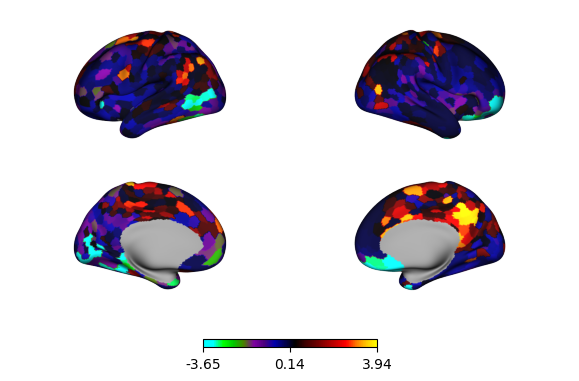

In [51]:
import numpy as np
from mapalign import embed
from sklearn.metrics import pairwise_distances
import ciftools_FA as ct
import hcp_utils as hcp
import nibabel as nib
from sklearn.decomposition import PCA


atlas = nib.load("/home/fralberti/Data/Shaefer2018_HCP/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii")
label_df = ct.label_df(atlas)
nws = ["Vis", "SomMot", "DorsAttn", "SalVentAttn", "Limbic", "Cont", "Default"]

for i, nw in enumerate(nws):
    label_df.loc[label_df.name.str.contains(nw), "NW"] = i
label_df.dropna(inplace=True)

tseries = np.loadtxt("/home/fralberti/Data/HCP_S1200/Subjects/100307/Analysis/100307.rfMRI_REST1_LR.Schaefer_1000.tseries.csv", delimiter=",")

def compute_affinity(X, threshold=90):
    A = np.corrcoef(X)
    thresholds = np.percentile(A, threshold, axis=0)
    A[A<thresholds] = 0
    A = 1 - pairwise_distances(A, metric = 'cosine')

    return A

A = compute_affinity(tseries, threshold=95)
full_pca = PCA(n_components=3).fit(A)
full_ts = full_pca.transform(A)




from variograd_utils import *
from surfplot import Plot

map = atlas.get_fdata().squeeze()

for i in np.arange(map.max()):
    i = np.int32(i)
    map[map==i+1] = full_ts[i, 1]


data = dataset()
lh = data.group_dir + "/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii"
rh = data.group_dir + "/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii"

map = {"left": map[:hcp.vertex_info.num_meshl], "right": map[hcp.vertex_info.num_meshl:]} 

p = Plot(surf_lh=lh, surf_rh=rh, layout="grid", zoom=1.3, size=(650,350))
p.add_layer(map, cmap="roy_big_bl")
fig = p.build()


In [61]:
window = 50
step = window//2

twise_pca = []
for start in range(0,1200-step, step):
    end = start + window
    A_t = compute_affinity(tseries[:, start:end])
    A_t = full_pca.transform(A_t)
    twise_pca.append(A_t)

twise_pca = np.array(twise_pca)
twise_pca.shape

(47, 1000, 3)

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set(xlim=(twise_pca[:,:,:3].min(), twise_pca[:,:,:3].max()),
       ylim=(twise_pca[:,:,:3].min(), twise_pca[:,:,:3].max()),
       zlim=(twise_pca[:,:,:3].min(), twise_pca[:,:,:3].max()),
       xlabel="Gradient1", 
       ylabel="Gradient2",
       zlabel="Gradient3")



N = 1000

# Create an empty plot object (we'll update this in the animation)
scat = ax.scatter([], [], [])

# Animation function
c = full_ts[:,0].copy()
c[c<0] = c[c<0]/c.min() * -1
c[c>0] = c[c>0]/c.max()
colors = plt.cm.jet(c)

def update(frame):
    # ax.view_init(azim=np.arange(0, 361, 360 // twise_pca.shape[0])[frame])
    ax.set_title(f"Frame: {frame}")
    scat._offsets3d = (twise_pca[frame, :, 0], twise_pca[frame, :, 1], twise_pca[frame, :, 2])
    scat.set_facecolors(colors)

# Create animation
ani = FuncAnimation(fig, update, frames=twise_pca.shape[0], interval=150)

# Save animation as gif
ani.save('animation.gif', writer='pillow')

plt.show()


In [54]:
import numpy as np
import seaborn as sns
from variograd_utils import *
from scipy.stats import zscore

x = dataset().load_gdist_triu("L")
x = dt[np.random.randint(0, len(dt), 3000)]
y = 1 / (1 + x / 50)


sns.jointplot(x=x, y=y)

In [47]:
import numpy as np
from scipy import stats, linalg
from scipy.sparse.linalg import svds
from mvlearn.embed import GCCA
from sklearn.preprocessing import normalize

rank=3
Xs = [np.random.randn(520, 48), np.random.randn(520, 48)]

Uall=[]
Sall=[]
Vall=[] 

for mat in Xs:
    X = stats.zscore(mat.copy(), axis=1, ddof=1)
    mu = np.mean(X, axis=0)
    X -= mu


    # Compute individual embeddings
    u, s, vt = svds(X, k=rank, which="LM", random_state=0)
    sorter = np.argsort(-s)
    v = vt.T
    v = v[:, sorter]
    ut = u.T
    u = ut.T[:, sorter]
    s = s[sorter]

    Uall.append(u)
    Sall.append(s)
    Vall.append(v)

N = len(Uall)
Uall = np.hstack(Uall)
Sall = np.array(Sall)
Vall = np.array(Vall)   




_, _, VV = svds(Uall, k=rank)
VV = np.flip(VV.T, axis=1)
VV = VV[:, : rank]

projection_mats = []
idx_end = 0

for i in range(2):
    idx_start = idx_end
    idx_end = idx_start + rank
    VVi = normalize(VV[idx_start:idx_end, :], "l2", axis=0)

    A = np.sqrt(N - 1) * Vall[i][:, : rank]
    A = A @ (linalg.solve(
        np.diag(Sall[i][: rank]), VVi
        ))
    projection_mats.append(A)

gcca = []

# Canonical projections
for i, mat in enumerate(Xs):

    X = stats.zscore(mat.copy(), axis=1, ddof=1)
    mu = np.mean(X, axis=0)
    X -= mu

    Xfit = X @ projection_mats[i]
    gcca.append(Xfit)

In [50]:
print(Sall.shape, VV.shape, Uall.shape, X.shape, A.shape, Xfit.shape)
# print(np.diag(S.shape), VVi.shape, U.shape, X.shape, A.shape)


(2, 3) (6, 3) (520, 6) (520, 48) (48, 3) (520, 3)


In [24]:
gcca3 = GCCA(n_components=rank)
gcca3 = gcca3.fit(Xs)
gcca3 = gcca3.transform(Xs)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


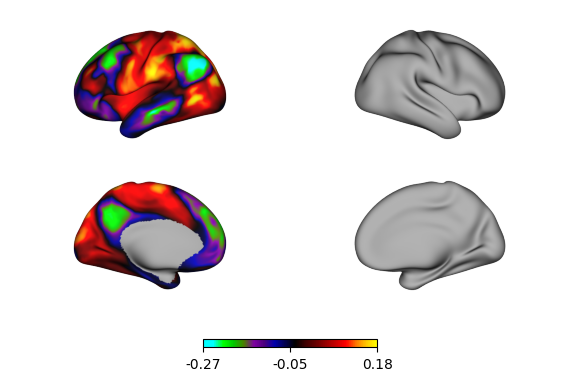

In [1]:

from variograd_utils import *
import nibabel as nib
import hcp_utils as hcp
from surfplot import Plot

gcca = np.load("/home/fralberti/Downloads/207123.GCCA.npy").T

data = dataset()
lh = data.group_dir + "/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii"
rh = data.group_dir + "/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii"

map = {"left": hcp.left_cortex_data(gcca[0, :hcp.vertex_info.grayl.size])} 

p = Plot(surf_lh=lh, surf_rh=rh, layout="grid", zoom=1.3, size=(650,350))
p.add_layer(map, cmap="roy_big_bl")
fig = p.build()


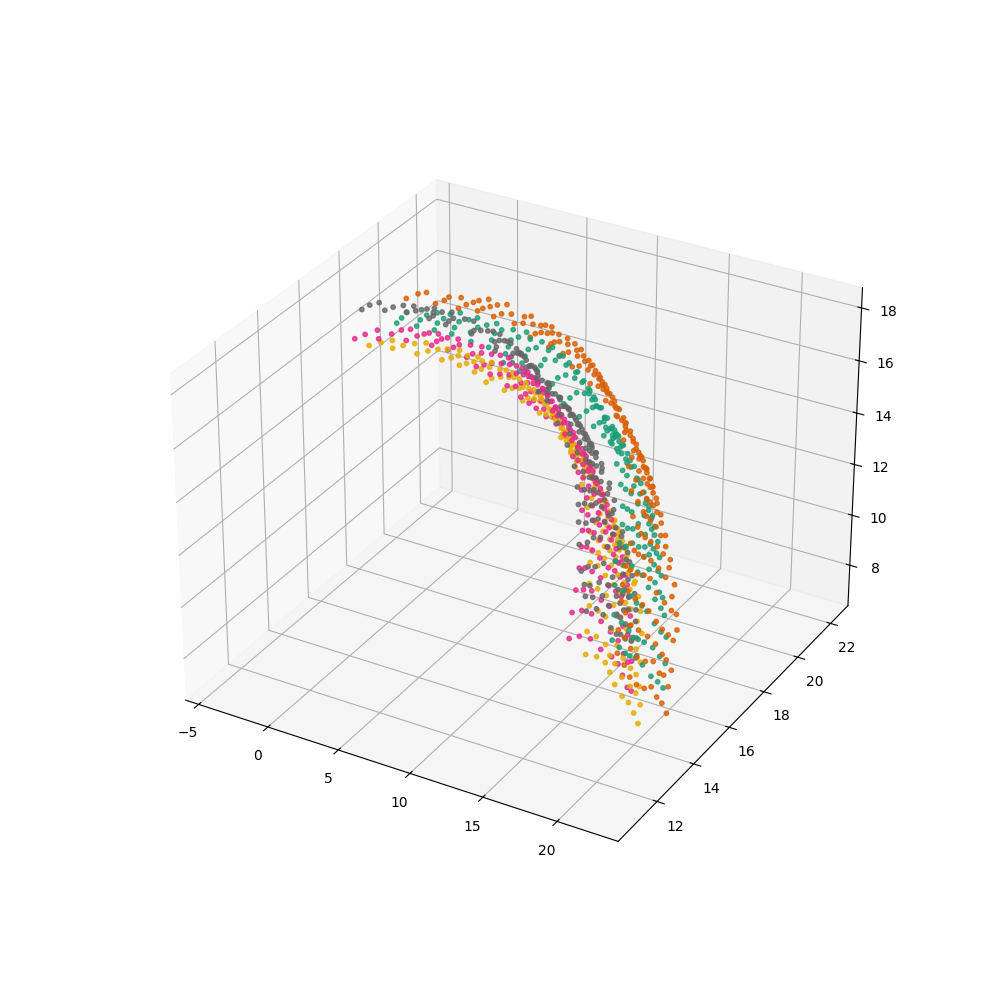

In [16]:
from variograd_utils import *
import matplotlib.pyplot as plt
%matplotlib widget

embed  = dataset().load_embeddings("L", "GCCA_r100")["GCCA_r100"][:5, 300:500, :3]

f, a = plt.subplots(1, 1, subplot_kw={"projection":"3d"}, figsize=(10,10))

a.scatter(embed[:, :, 0].flatten(), 
          embed[:, :, 1].flatten(),
          embed[:, :, 2].flatten(), s=10, c=np.repeat(range(embed.shape[0]), embed.shape[1]), cmap="Dark2_r", alpha=.8)